#### Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import warnings

In [ ]:
# Custom imports
import utils
import model_utils

In [2]:
# Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introduction](#intro)<br>
2. [Data Loading](#dl)<br>
    2.1 [Preprocessing](#pp)<br>
3. [Modelling](#modelling)<br>
    3.1 [Downsampling](#downsampling)<br>
    3.2 [Upsampling](#upsampling)<br>
    3.3 [SMOTE](#smote)<br>
4. [Feature Engineering](#fe)<br>
5. [Dimensionality Reduction with PCA](#dim_reduc)<br>
6. [Model Optimisation](#optimisation)<br>
    6.1 [Saving the model](#save)<br>
    6.2 [Loading the model](#load)<br>
7. [Remarks on Logistic Regression](#conc)

<a id='intro'></a>

# Introduction

Previously we tried to use regression models to predict the size of a wildfire on the features found within our data set. Unfortunately, these regression models performed poorly, even when simplifying the task to predict fires from the first four classes (A-D). Consequently, we decided that a model might perform better if given a classification task -  classifying the class that a fire will belong to - which has lead us to the current stage.

Logistic regression is a statistical technique used to predict the probability of an event occurring. The logistic regression coefficients represent the change in the log odds of the event occurring for each unit increase in the predictor variable. For example, if the log odds of an event occurring is 0.1 and the coefficient for age is 0.05, then for each year increase in age, the log odds of the event occurring increases by 0.05.

---
<a id='dl'></a>

## Data Loading

In [3]:
df = utils.LoadDf()

# Check output
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


In [4]:
utils.BasicEda(df, 'Wildfires', ['shape', 'columns', 'dtypes'])

WILDFIRES
---------

Rows: 29734    Columns: 34

FIRE_YEAR               int64
DISCOVERY_DOY           int64
FIRE_SIZE             float64
FIRE_SIZE_CLASS        object
LATITUDE              float64
LONGITUDE             float64
STATE                  object
avg_tempmax           float64
avg_temp              float64
avg_humidity          float64
avg_precip            float64
avg_dew               float64
avg_windspeed         float64
avg_winddir           float64
avg_pressure          float64
ch4                   float64
co2                   float64
n2o                   float64
tempmax_variance      float64
tempmax_delta         float64
temp_variance         float64
temp_delta            float64
humidity_variance     float64
humidity_delta        float64
precip_variance       float64
precip_delta          float64
dew_variance          float64
dew_delta             float64
windspeed_variance    float64
windspeed_delta       float64
winddir_variance      float64
winddir_delta        

<a id='pp'></a>
### Preprocessing

In [5]:
df = utils.BasicCategoricalPreprocessing(df)
df,_ = utils.BasicNumericPreprocessing(df)

In [6]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.10,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.00,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0
2,1992,2,0.25,A,40.775000,-74.854160,6.385714,1.585714,67.185714,1.394286,...,0,0,0,0,0,0,0,0,0,0
3,1992,3,1.91,B,31.018500,-83.297300,14.457143,11.828571,78.957143,4.685714,...,0,0,0,0,0,0,0,0,0,0
4,1992,3,2.00,B,30.728900,-87.238100,14.428571,10.985714,79.971429,0.188571,...,0,0,0,0,0,0,0,0,0,0


---
<a id='modelling'></a>

## Modelling

As we saw from the initial model that we ran in a previous notebook, the accuracy of the model was severely affected by the distribution of the fires. As a classification model, the baseline model that we created initially was very poor at distinguishing between the different fire sizes, opting to classify most fires as coming from `FIRE_SIZE_CLASS` B, as this was the most common. We therefore want to begin this modelling process by creating an even distribution in our samples. We can do this in a number of ways: we can upsample, downsample, and use methods such as SMOTE. To begin, we will downsample, selecting an equal amount of each class from the data we have available. It should be noted that this is the least popular resampling method, as we are reducing the number of observations. 

Before we do this let us remind ourselves of the distribution of the `FIRE_SIZE` and `FIRE_SIZE_CLASS` variables:

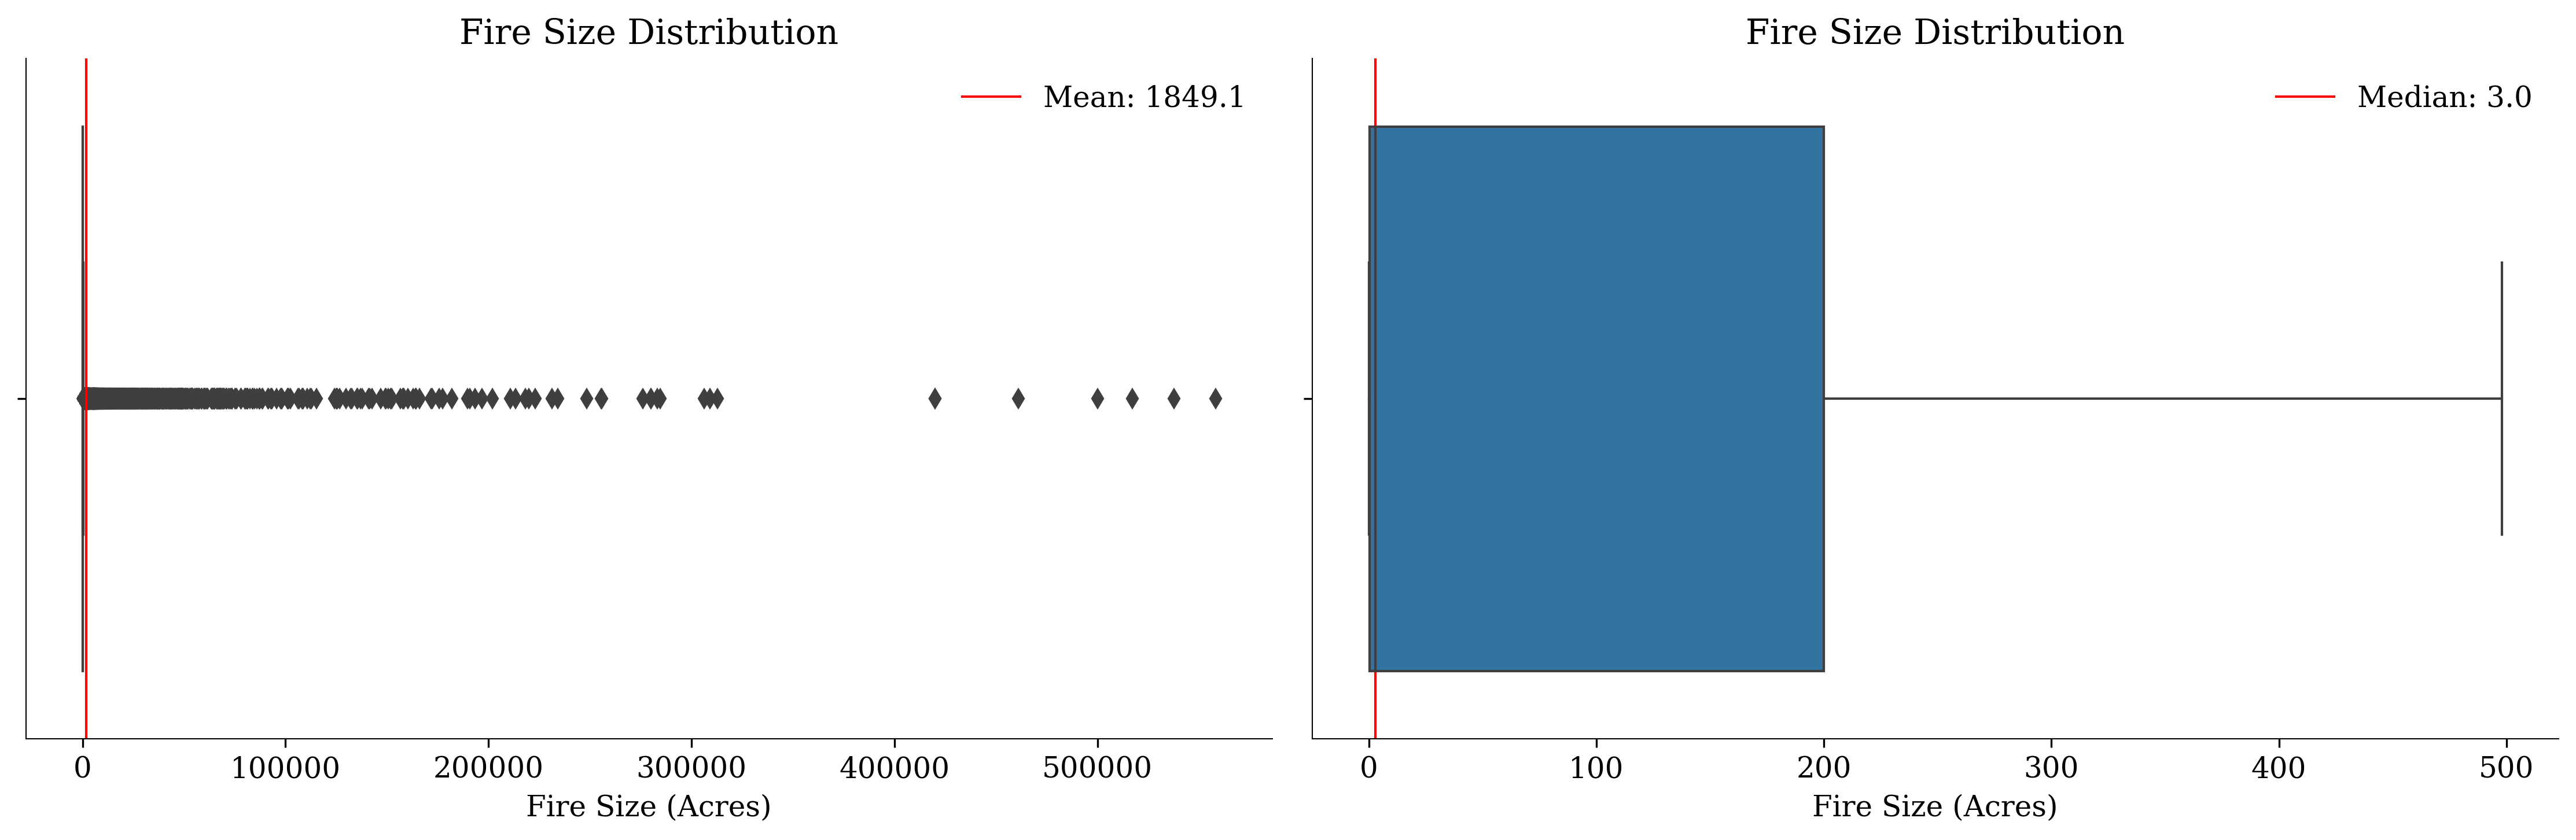

In [7]:
utils.PlotFireSizeDistribution(df)

As we can see, the distribution of the fire sizes is extremely skewed. The median value is extremely small, whereas the mean is far larger in comparison. Consquently, the distribution of `FIRE_SIZE_CLASS` is equally uneven.

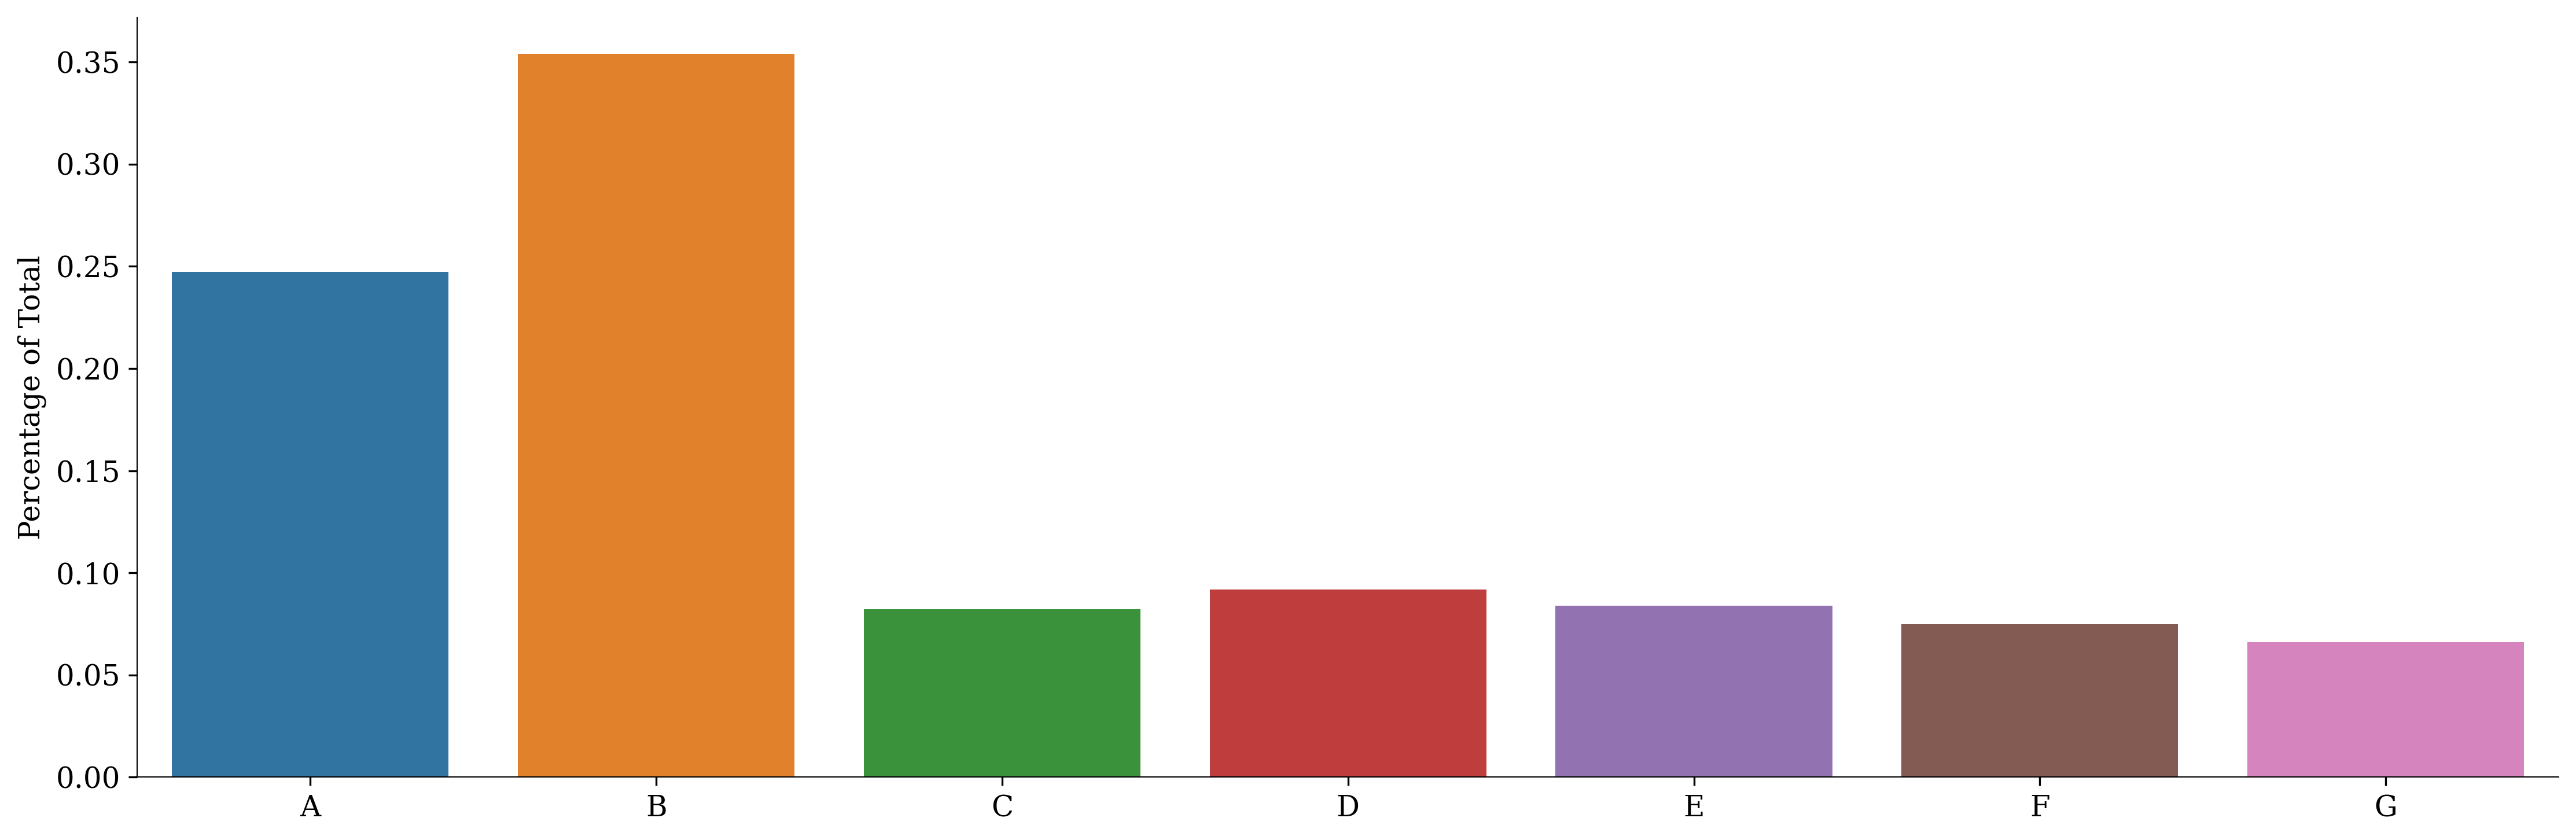

In [8]:
fire_size_class_df = utils.count_percentage_df(df['FIRE_SIZE_CLASS']).sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(data=fire_size_class_df,
            x=fire_size_class_df.index,
            y='Percentage of Total')
plt.show()

<a id='downsampling'></a>

### Downsampling

As we want to get even samples from each class, we first need to see the way in which the samples are distributed.

In [9]:
fire_size_class_df

,Count,Percentage of Total
A,7355,0.247360
B,10529,0.354106
C,2441,0.082095
D,2728,0.091747
E,2494,0.083877
F,2222,0.074729
G,1965,0.066086


We see that the lowest value, unsurprisingly, is `FIRE_SIZE_CLASS` G, which has 1965 observations. We will therefore take samples of size 1965 from each of the other classes, to get an even distribution.

In [10]:
# Create DataFrame
df_condensed = pd.DataFrame()

# Get the fire classes
fire_classes = df['FIRE_SIZE_CLASS'].unique()

# Get equal sample from each FIRE_SIZE_CLASS
for fire_class in fire_classes:
    tmp = df[df['FIRE_SIZE_CLASS'] == fire_class]
    df_condensed = pd.concat([df_condensed, tmp.sample(1965)])

In [11]:
df_condensed.shape

(13755, 85)

In [12]:
utils.count_percentage_df(df_condensed['FIRE_SIZE_CLASS'])

,Count,Percentage of Total
A,1965,0.142857
B,1965,0.142857
C,1965,0.142857
D,1965,0.142857
E,1965,0.142857
F,1965,0.142857
G,1965,0.142857


Having collected an even distribution of samples, we will now create a Logistic Regression. As with the Linear Regression model, we will use the same scaling methods as previously.

In [14]:
from sklearn.model_selection import train_test_split

X = df_condensed.drop(['FIRE_SIZE','FIRE_SIZE_CLASS'], axis=1)
y = df_condensed['FIRE_SIZE_CLASS']

# Create column transformer
col_transformer = model_utils.CreateColumnTransformer(X)

# Create remainder and test
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [15]:
# Transform the train and validation set
X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=10000, random_state=1)

In [17]:
logreg.score(X_train_transformed, y_train)

0.32915303525990547

In [18]:
X_test_transformed =  col_transformer.transform(X_test)
logreg.score(X_test_transformed, y_test)

0.3038894947291894

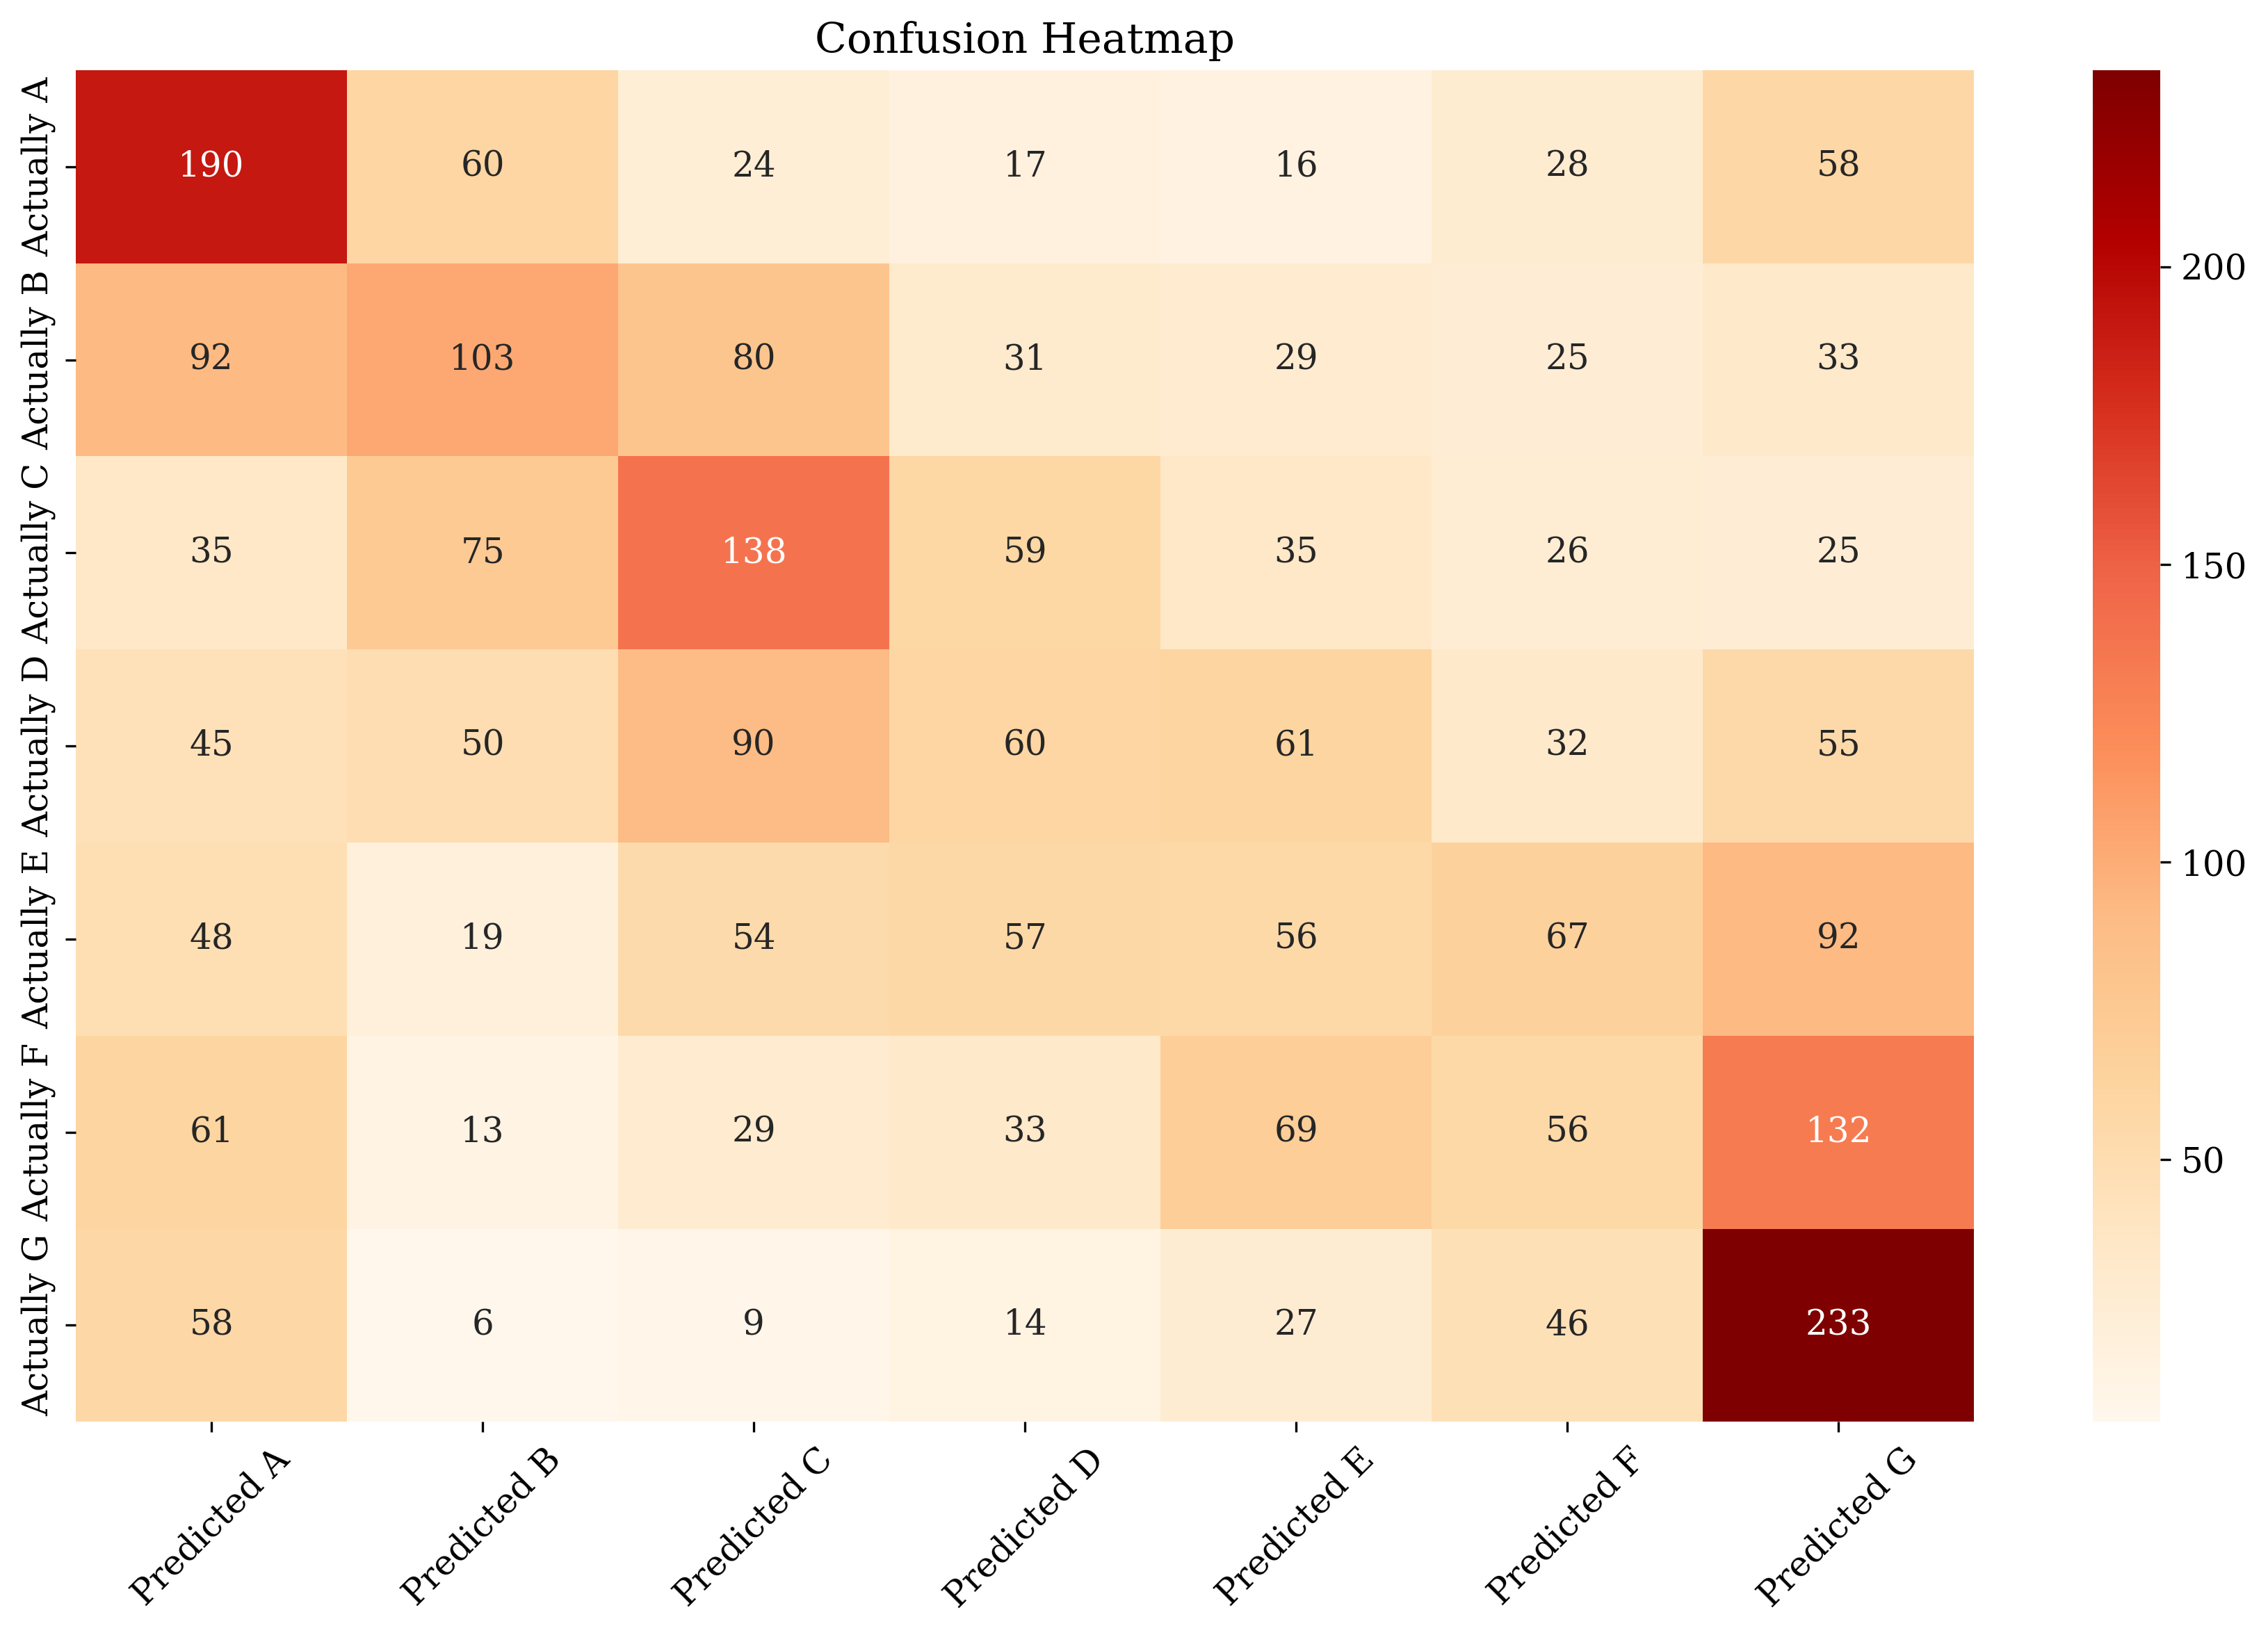

              precision    recall  f1-score   support

           A       0.36      0.48      0.41       393
           B       0.32      0.26      0.29       393
           C       0.33      0.35      0.34       393
           D       0.22      0.15      0.18       393
           E       0.19      0.14      0.16       393
           F       0.20      0.14      0.17       393
           G       0.37      0.59      0.46       393

    accuracy                           0.30      2751
   macro avg       0.28      0.30      0.29      2751
weighted avg       0.28      0.30      0.29      2751



In [19]:
model_utils.PlotConfusionMatrix(logreg, X_test_transformed, y_test)

Although the baseline model that we created had a better accuracy score, it did not improve upon the dummy model. In this instance, although we have a lower accuracy score, the model is better at predicting the class of a fire by $\approx16.1$%.

<a id='upsampling'></a>
### Upsampling

In [20]:
# Upsampling using resample
from sklearn.utils import resample

# Get X and y variables
X, y = model_utils.GenerateXy(df)

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# Print Distribution of classes
utils.count_percentage_df(y_train)

,Count,Percentage of Total
B,8409,0.353512
A,5851,0.245975
D,2172,0.091310
E,2023,0.085046
C,1990,0.083659
F,1791,0.075293
G,1551,0.065204


In [21]:
filter = ~((y_train == 'B') + (y_train =='A'))

X_upsampled, y_upsampled = resample(X_train[filter], 
                                    y_train[filter],
                                    n_samples=X_train[y_train=='B'].shape[0]*5,
                                    random_state=1)

utils.count_percentage_df(y_upsampled)

,Count,Percentage of Total
D,9692,0.230515
E,8939,0.212606
C,8794,0.209157
F,7762,0.184612
G,6858,0.163111


In [22]:
# Combine upsample with original data
X_train_bal = np.vstack((X_train[(y_train == 'B') + (y_train =='A')], X_upsampled))
y_train_bal = np.hstack((y_train[(y_train == 'B') + (y_train =='A')], y_upsampled))

# Check updated distribution
utils.count_percentage_df(pd.Series(y_train_bal))

,Count,Percentage of Total
D,9692,0.172134
E,8939,0.158760
C,8794,0.156185
B,8409,0.149347
F,7762,0.137856
G,6858,0.121801
A,5851,0.103916


In [23]:
X_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)

In [24]:
X_train_bal_transformed = col_transformer.fit_transform(X_train_bal)

In [25]:
logreg_balanced = LogisticRegression(max_iter=10000, random_state=1)
logreg_balanced.fit(X_train_bal_transformed, y_train_bal)

LogisticRegression(max_iter=10000, random_state=1)

In [27]:
logreg_balanced.score(X_test, y_test)

0.06961493189843619

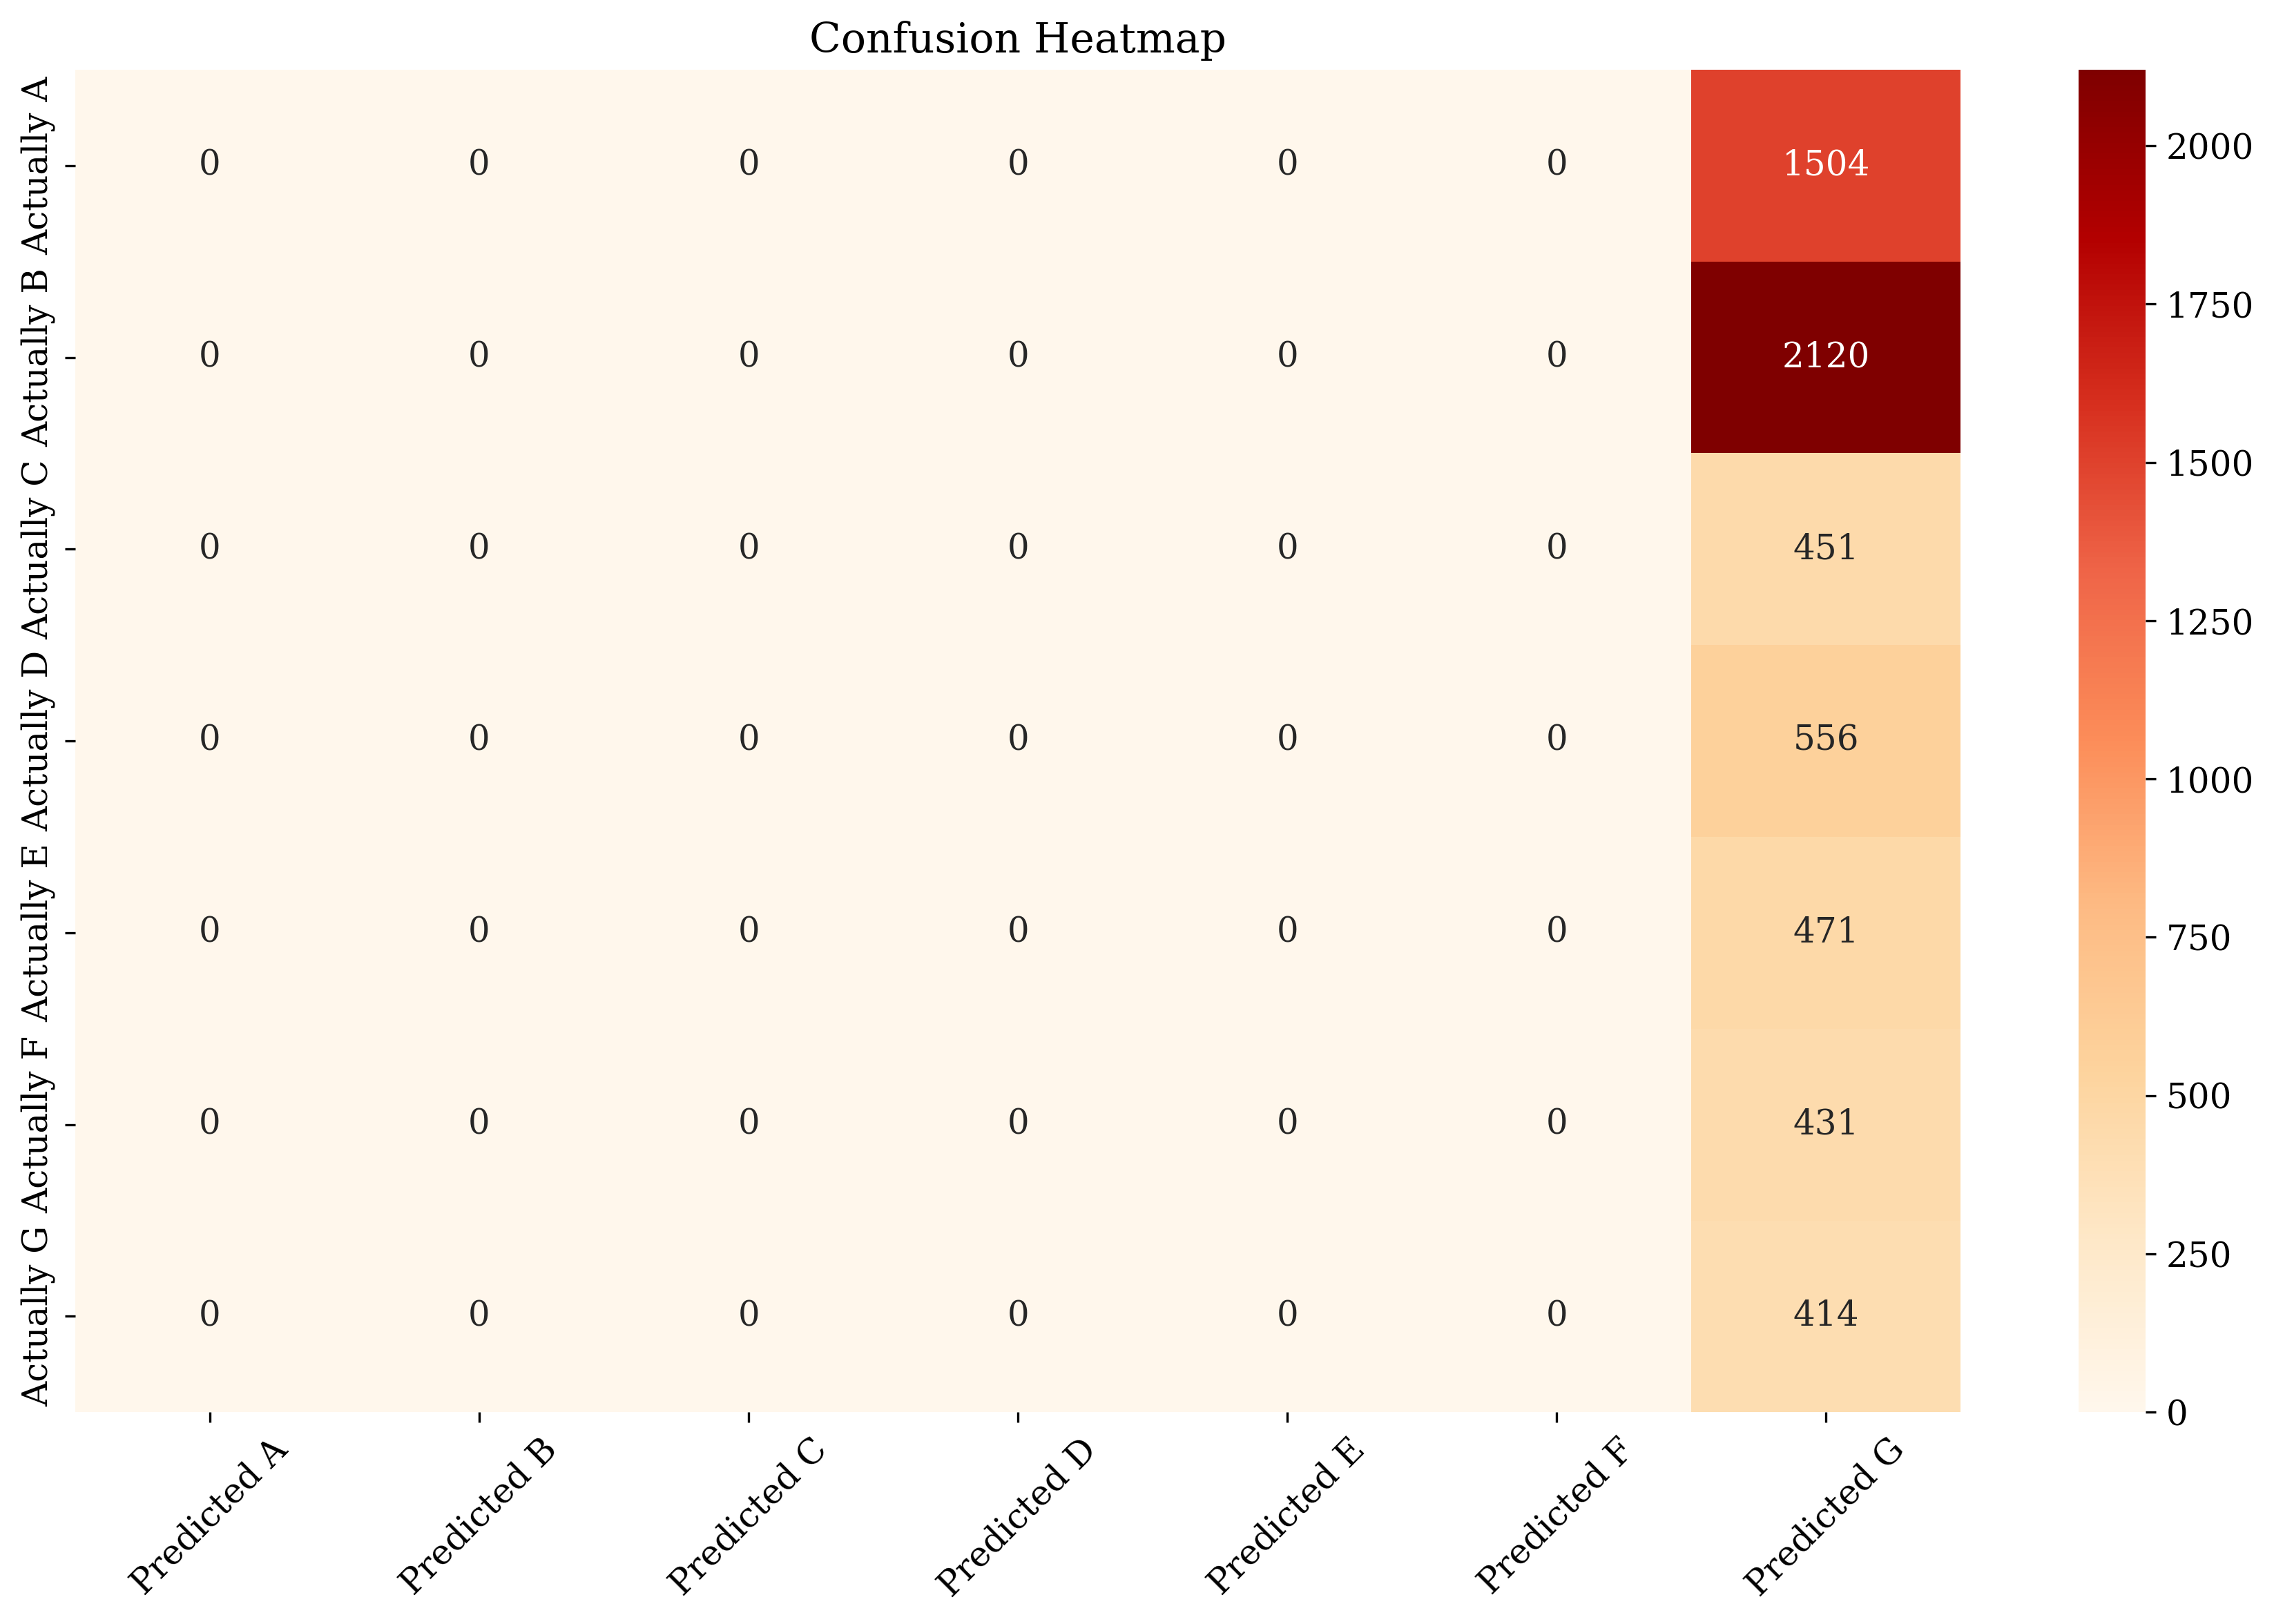

              precision    recall  f1-score   support

           A       0.00      0.00      0.00      1504
           B       0.00      0.00      0.00      2120
           C       0.00      0.00      0.00       451
           D       0.00      0.00      0.00       556
           E       0.00      0.00      0.00       471
           F       0.00      0.00      0.00       431
           G       0.07      1.00      0.13       414

    accuracy                           0.07      5947
   macro avg       0.01      0.14      0.02      5947
weighted avg       0.00      0.07      0.01      5947



In [28]:
model_utils.PlotConfusionMatrix(logreg_balanced, X_test, y_test)

As we can see from the accuracy score, as well as the confusion matrix, upsampling was unsuccessful in improving the model. Surprisingly, the model predicts that all the fires are of `FIRE_SIZE_CLASS` G, which is surprising considering that in previous models there was at least some distinction between the models. Perhaps we can improve upon this model by using Synthetic Minority Oversampling Technique (SMOTE) as an alternative.

<a id='smote'></a>

### SMOTE

In [29]:
from imblearn.over_sampling import SMOTE

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [30]:
X_train_sm_transformed = pd.DataFrame(X_train_sm, columns=X.columns)
X_train_sm_transformed.shape

(58863, 83)

In [31]:
utils.count_percentage_df(y_train_sm)

,Count,Percentage of Total
B,8409,0.142857
E,8409,0.142857
A,8409,0.142857
C,8409,0.142857
D,8409,0.142857
G,8409,0.142857
F,8409,0.142857


This time, we have been able to generate more samples than previously, while not simply just reusing samples as in the methods tried previously.

In [32]:
X_train_sm_transformed = col_transformer.transform(X_train_sm_transformed)

# Create base logistic regression
smote_logreg = LogisticRegression(max_iter=10000)
smote_logreg.fit(X_train_sm_transformed, y_train_sm)

LogisticRegression(max_iter=10000)

In [33]:
smote_logreg.score(X_train_sm_transformed, y_train_sm)

0.3791515892835907

In [34]:
X_test_transformed = col_transformer.transform(X_test)
smote_logreg.score(X_test_transformed, y_test)

0.42088447956953084

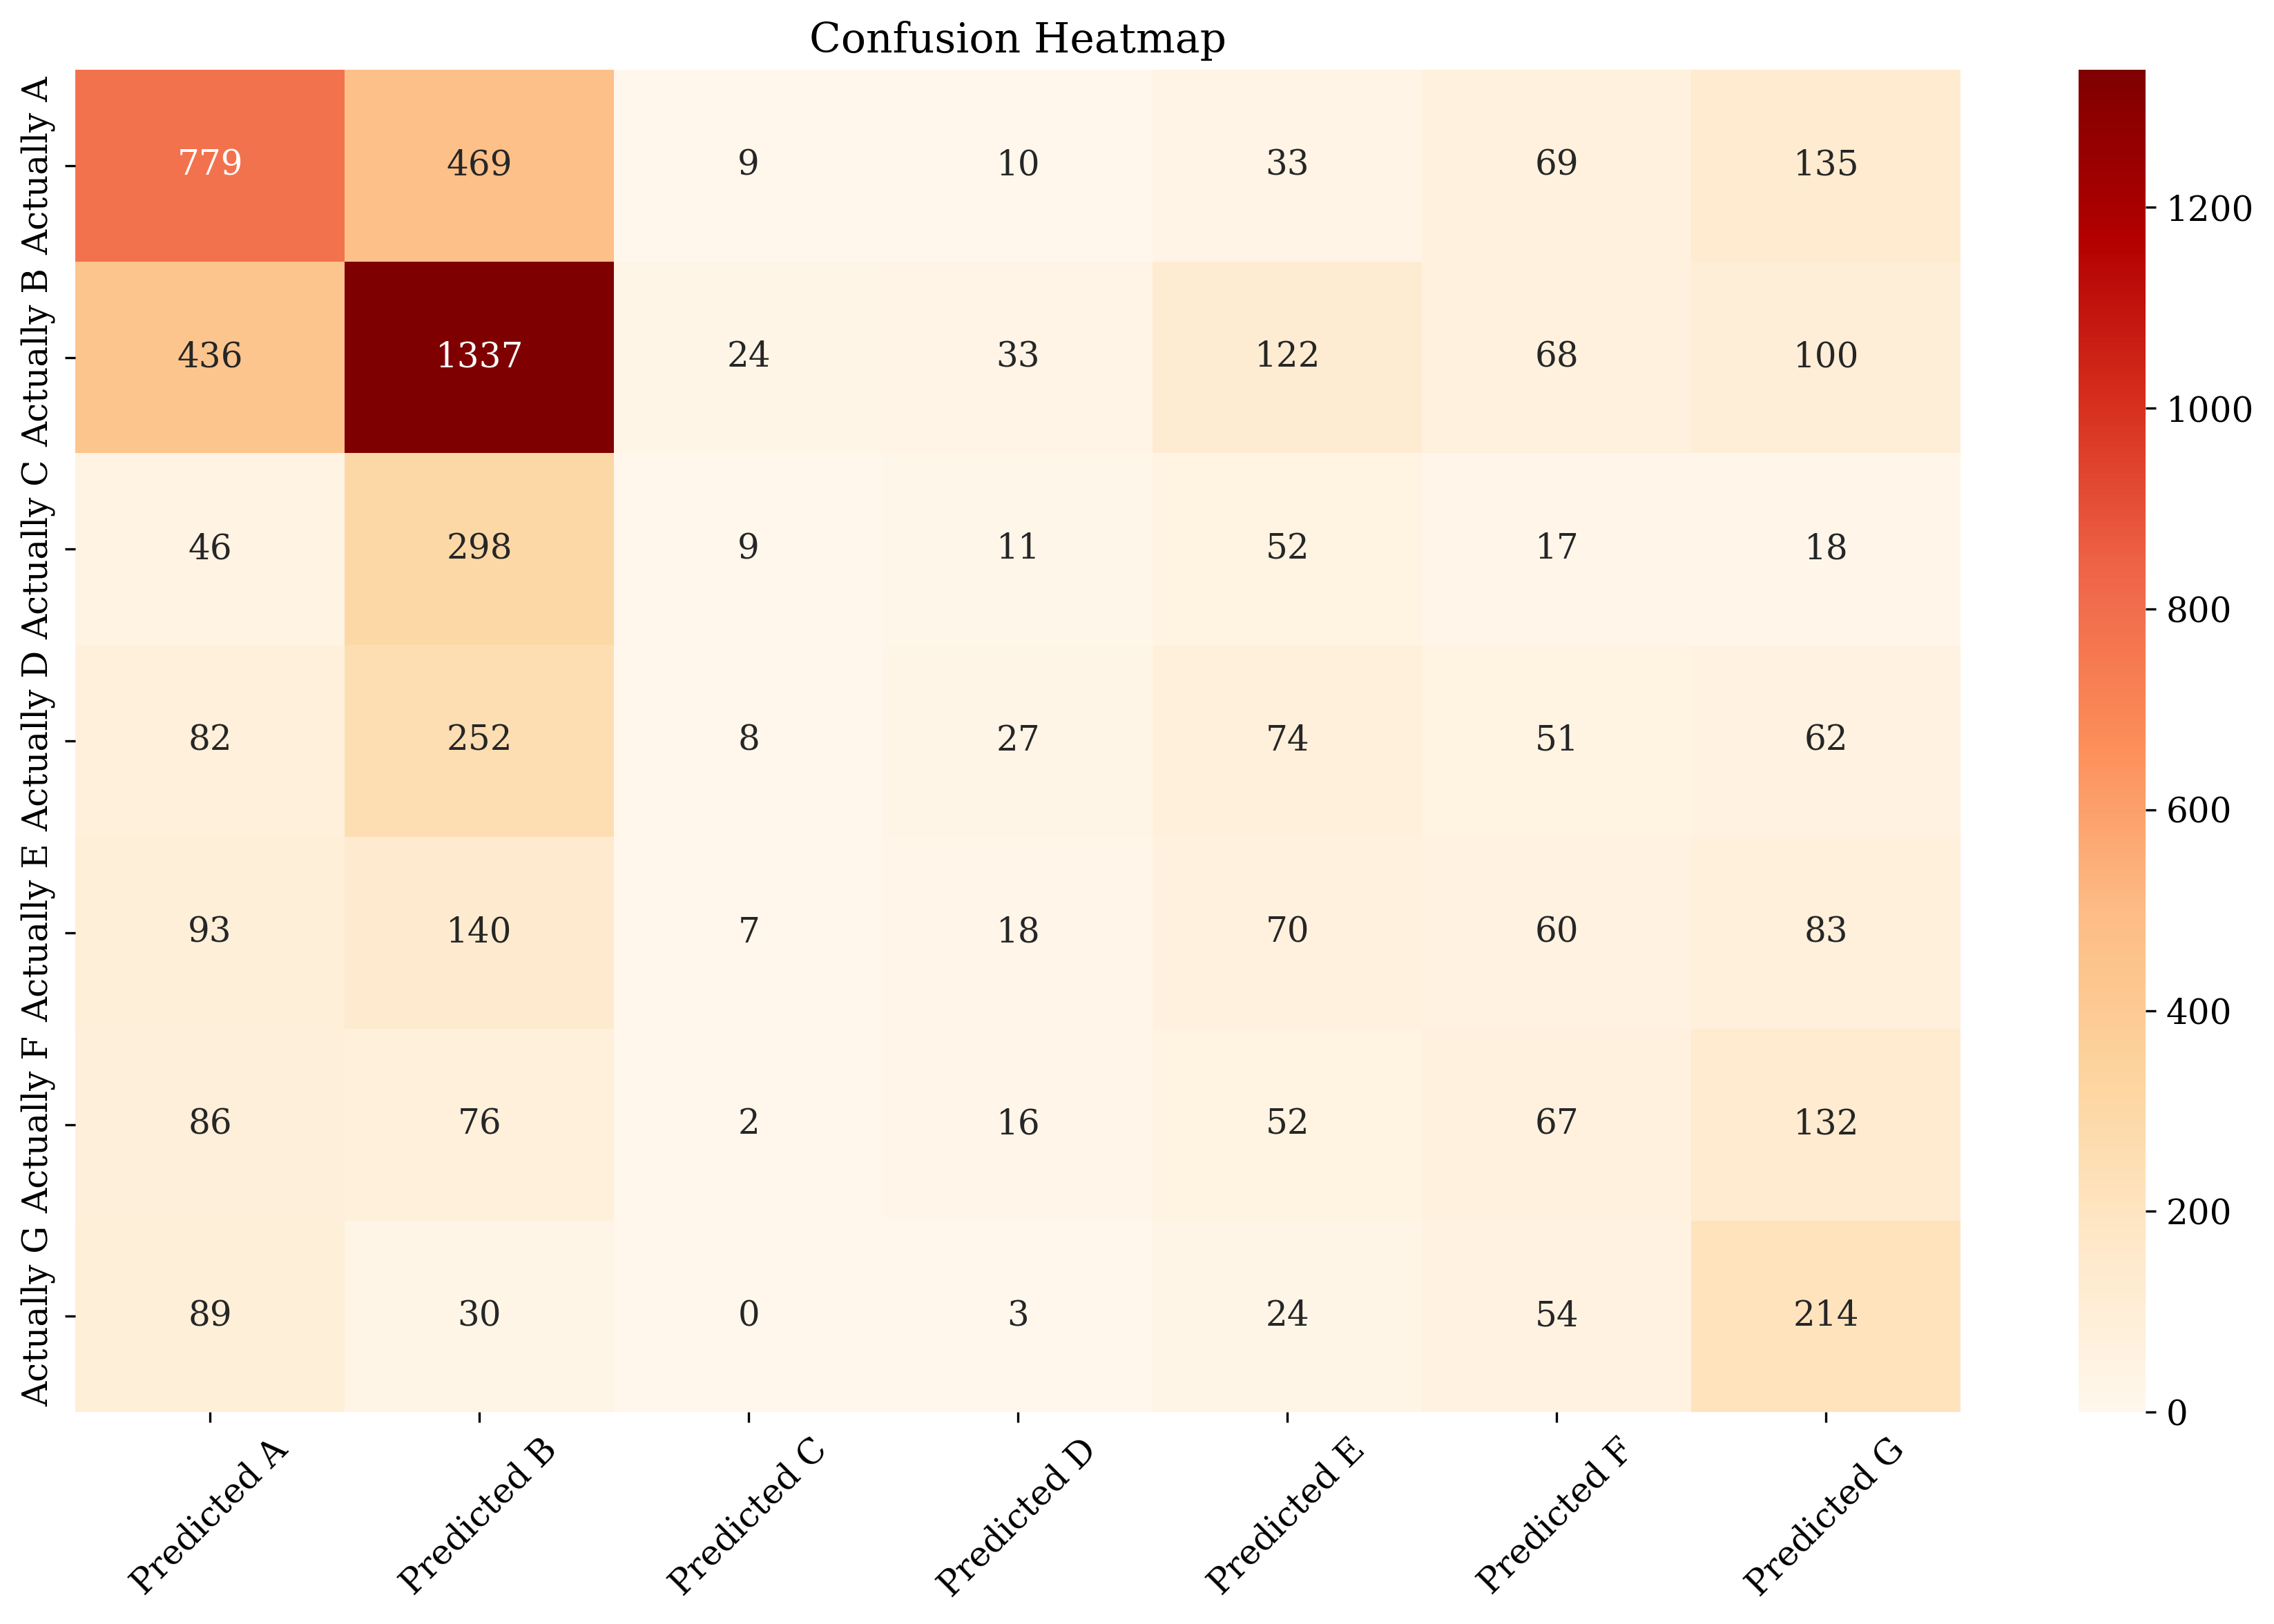

              precision    recall  f1-score   support

           A       0.48      0.52      0.50      1504
           B       0.51      0.63      0.57      2120
           C       0.15      0.02      0.04       451
           D       0.23      0.05      0.08       556
           E       0.16      0.15      0.16       471
           F       0.17      0.16      0.16       431
           G       0.29      0.52      0.37       414

    accuracy                           0.42      5947
   macro avg       0.29      0.29      0.27      5947
weighted avg       0.38      0.42      0.39      5947



In [35]:
model_utils.PlotConfusionMatrix(smote_logreg, X_test_transformed, y_test)

In this instance, we see that the accuracy has improved, but the model is still makes a lot of errors when predicting the minority classes, which SMOTE aimed to alleviate. We will continue to work with the SMOTE train and test sets, however we will try to optimise the model.

---
<a id='fe'></a>
## Feature Engineering

Using L1 penalty, we should be able to find the variables that account for the changes the most.

In [36]:
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1')
log_reg_l1.fit(X_train_sm_transformed, y_train_sm);

In [37]:
print(log_reg_l1.score(X_test_transformed, y_test))

0.4249201277955272


In [38]:
c_values = [10 ** x for x in range(-6, 6)]

train_accuracies = []
test_accuracies = []

for index, c in enumerate(c_values):
    print(f'Fitting Model {index+1}/{len(c_values)}', end='\r')
    log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=c, random_state=1)
    log_reg_l1.fit(X_train_sm_transformed, y_train_sm)
    
    train_accuracies.append(log_reg_l1.score(X_train_sm_transformed, y_train_sm))
    test_accuracies.append(log_reg_l1.score(X_test_transformed, y_test))    

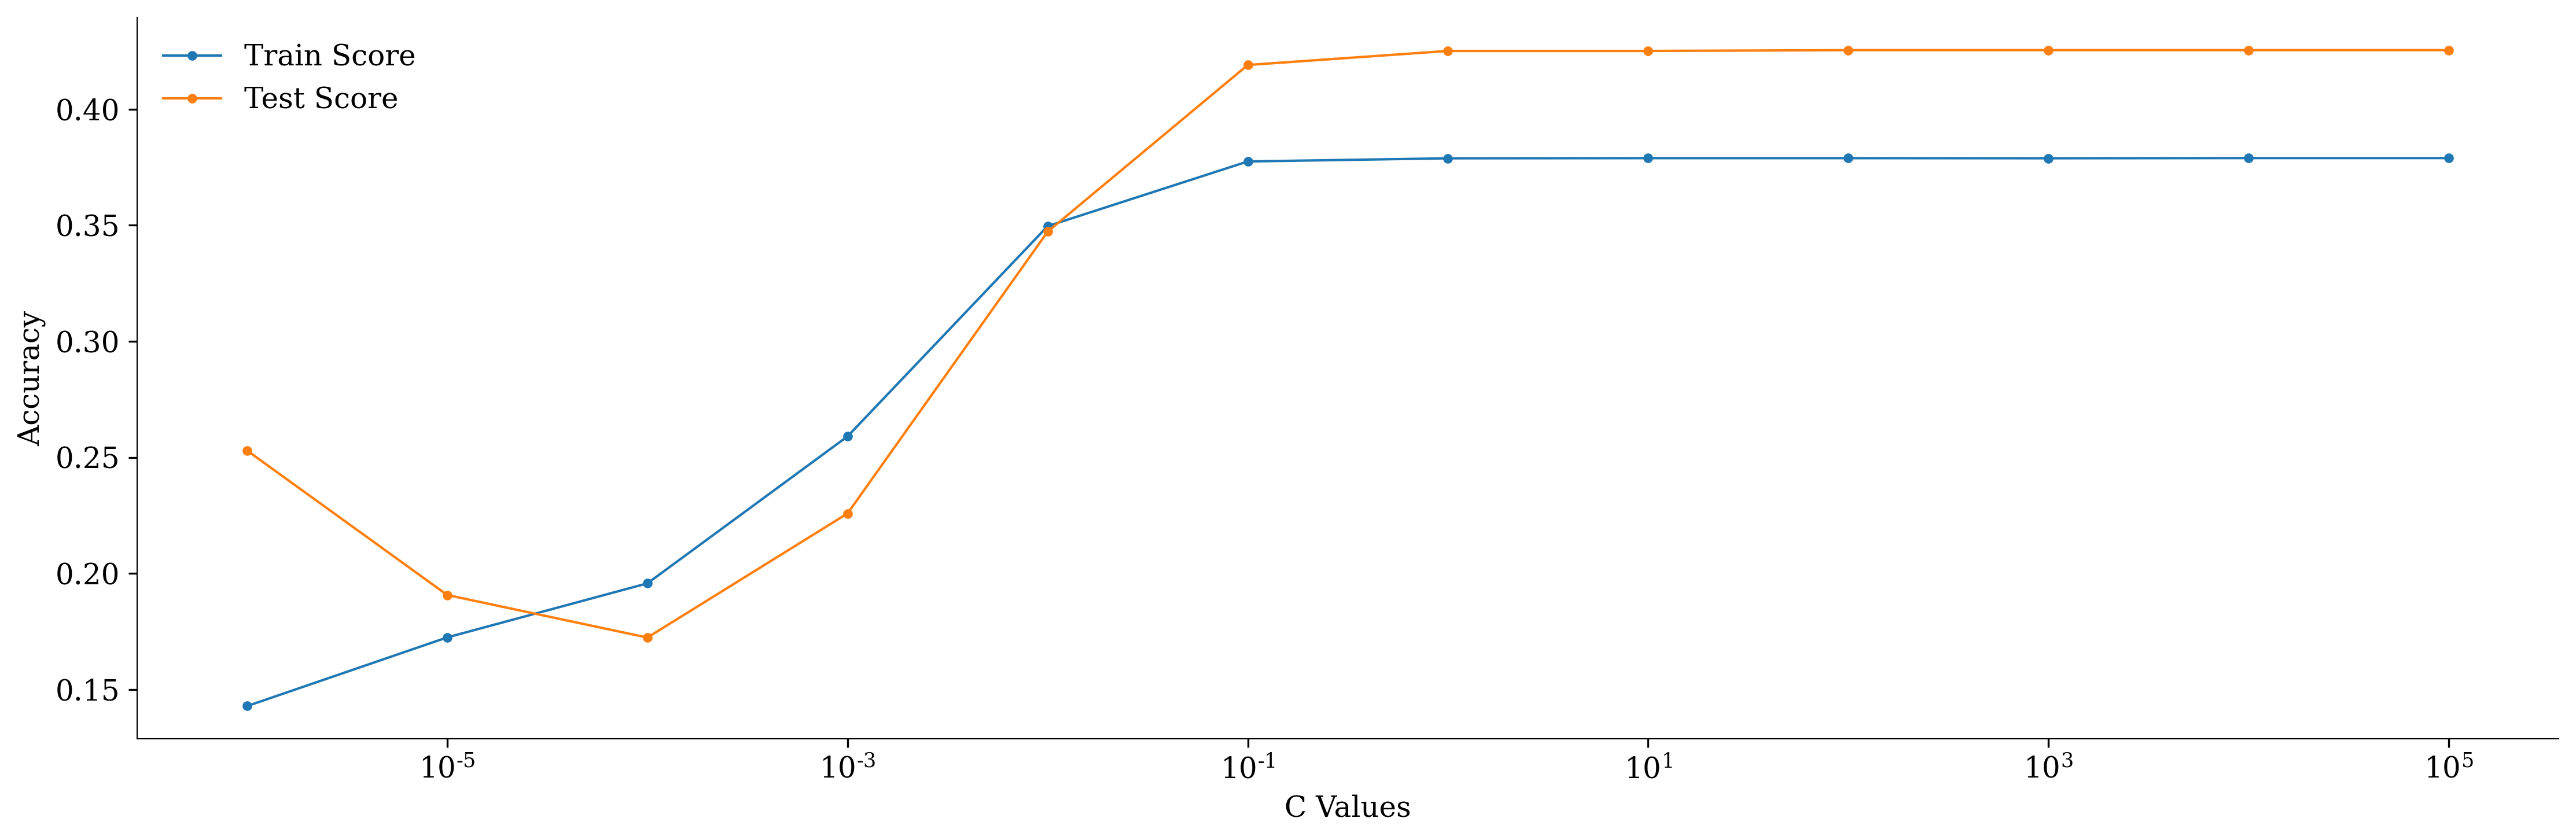

In [39]:
model_utils.PlotTrainTest(c_values, 'C Values', train_accuracies, test_accuracies, log=True)

In [41]:
print(f'The highest test accuracy was achieved with a c value of {c_values[np.argmax(test_accuracies)]}')

The highest test accuracy was achieved with a c value of 100


In [42]:
log_reg_c = LogisticRegression(solver='liblinear', penalty='l1', C=100)
log_reg_c.fit(X_train_sm_transformed, y_train_sm)

print(f'Test accuracy with a c value of 10: {log_reg_c.score(X_test_transformed, y_test)}')

Test accuracy with a c value of 10: 0.4255927358331932


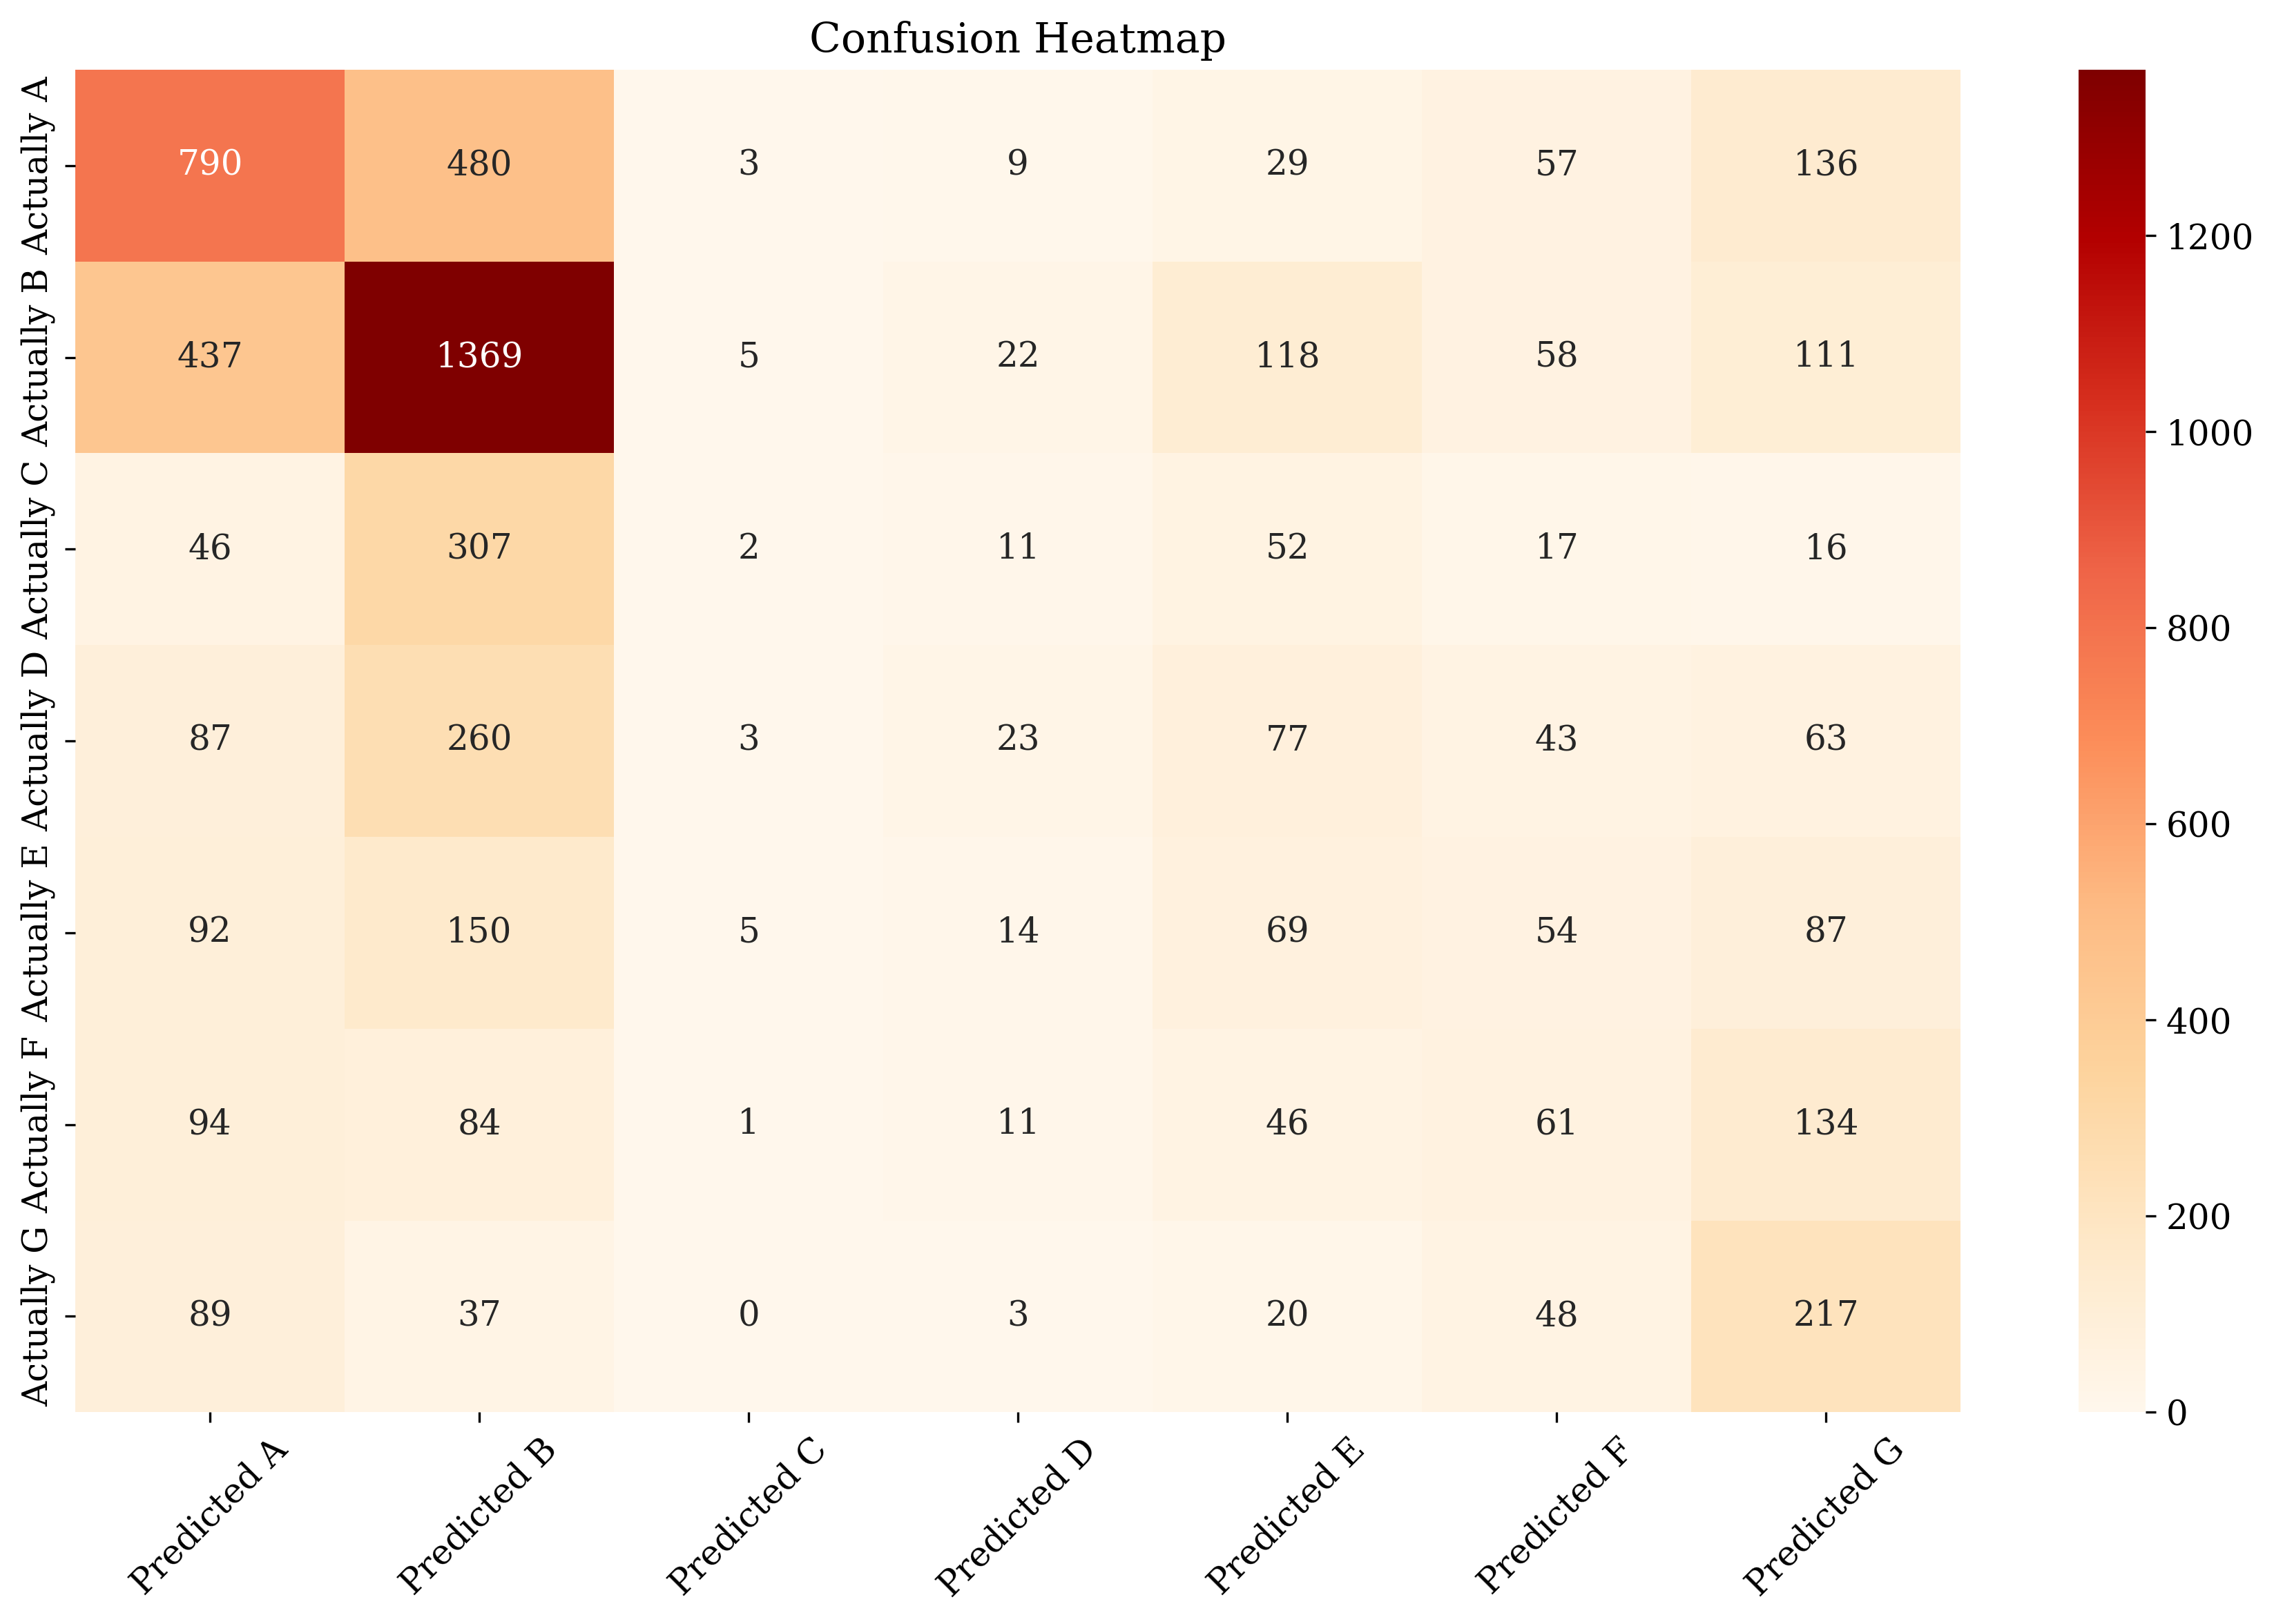

              precision    recall  f1-score   support

           A       0.48      0.53      0.50      1504
           B       0.51      0.65      0.57      2120
           C       0.11      0.00      0.01       451
           D       0.25      0.04      0.07       556
           E       0.17      0.15      0.16       471
           F       0.18      0.14      0.16       431
           G       0.28      0.52      0.37       414

    accuracy                           0.43      5947
   macro avg       0.28      0.29      0.26      5947
weighted avg       0.38      0.43      0.39      5947



In [43]:
model_utils.PlotConfusionMatrix(log_reg_c, X_test_transformed, y_test)

What are the values that the model deems the most important? Using a lower C value will reduce the number of features in the model as it will reduce their coefficients to 0. We can therefore use the L1 penalty in conjunction with a low C value to extract the most informative features.

In [44]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.0001)
logreg.fit(X_train_sm_transformed, y_train_sm)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [45]:
pd.set_option('display.max_columns', None)

In [46]:
pd.DataFrame(logreg.coef_, columns=X.columns)

,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,avg_dew,avg_windspeed,avg_winddir,avg_pressure,ch4,co2,n2o,tempmax_variance,tempmax_delta,temp_variance,temp_delta,humidity_variance,humidity_delta,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002424,-0.000263,0.0,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000404,-0.003932,0.0,-0.003013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003089,-0.002190,0.0,-0.007754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004226,0.000000,0.0,-0.004902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019366,-0.001084,0.0,-0.011066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030054,-0.002491,0.0,-0.016024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.063606,-0.005864,0.0,-0.035407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


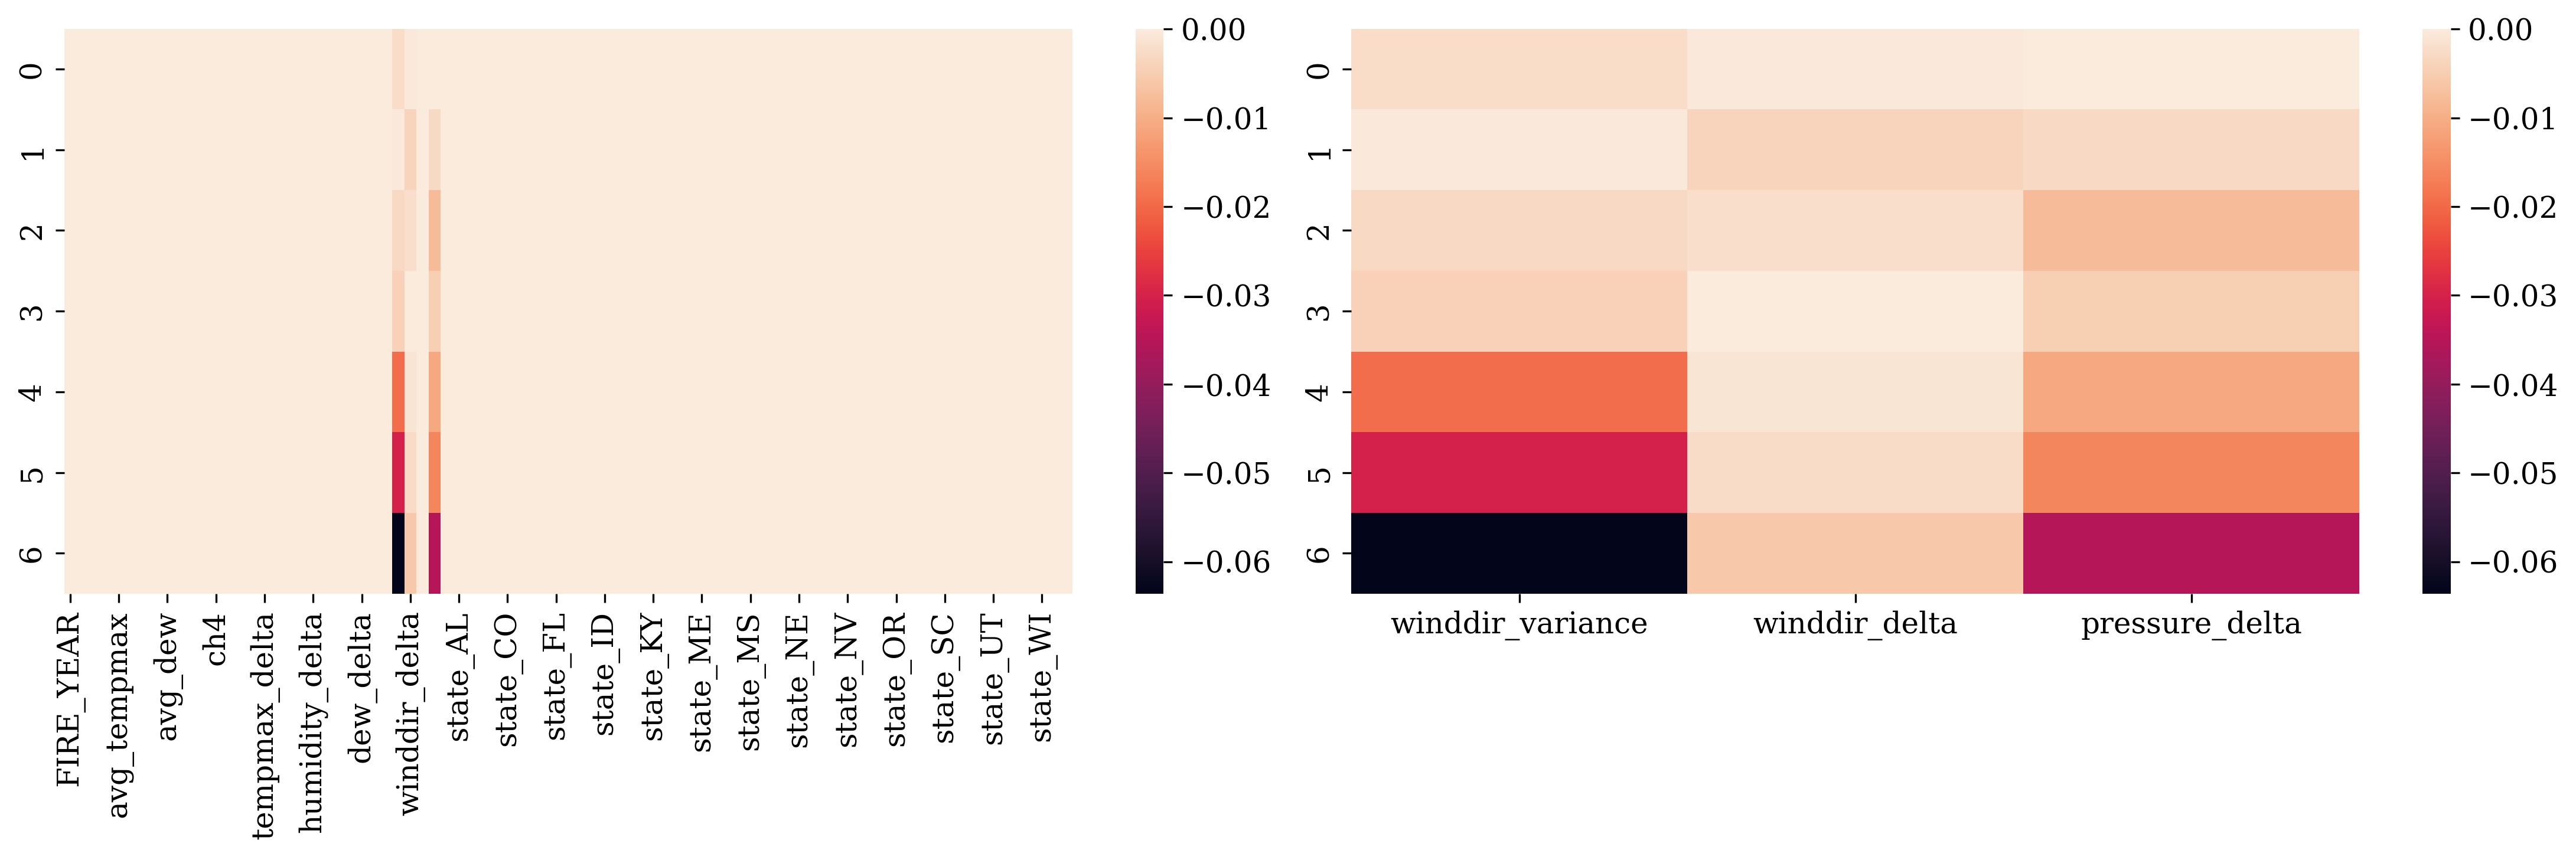

In [47]:
plt.subplots(1, 2, dpi=300, figsize=(15, 5))

# General Overview
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(logreg.coef_, columns=X.columns))

# Specific features
plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(logreg.coef_, columns=X.columns).loc[:, ['winddir_variance', 'winddir_delta', 'pressure_delta']])

plt.show()

These three variables, having used the L1 penalty as a form of feature reduction, are the most important. We can therefore build another model which only looks at these values.

In [48]:
X_reduced = X.loc[:, ['winddir_variance', 'winddir_delta', 'pressure_delta']]

# Create remainder and test
X_rem, X_test, y_rem, y_test = \
train_test_split(X_reduced, y, test_size=0.2, random_state=1, stratify=y)

# Create train and validation
X_train, X_validation, y_train, y_validation = \
train_test_split(X_rem, y_rem, test_size=0.3, random_state=1, stratify=y_rem)

In [50]:
from sklearn.preprocessing import StandardScaler

my_ss = StandardScaler()
X_train_transformed = my_ss.fit_transform(X_train)
X_test_transformed = my_ss.transform(X_test)

In [51]:
logreg_reduced = LogisticRegression(random_state=1)
logreg_reduced.fit(X_train_transformed, y_train);

In [52]:
logreg_reduced.score(X_test_transformed, y_test)

0.35412813183117536

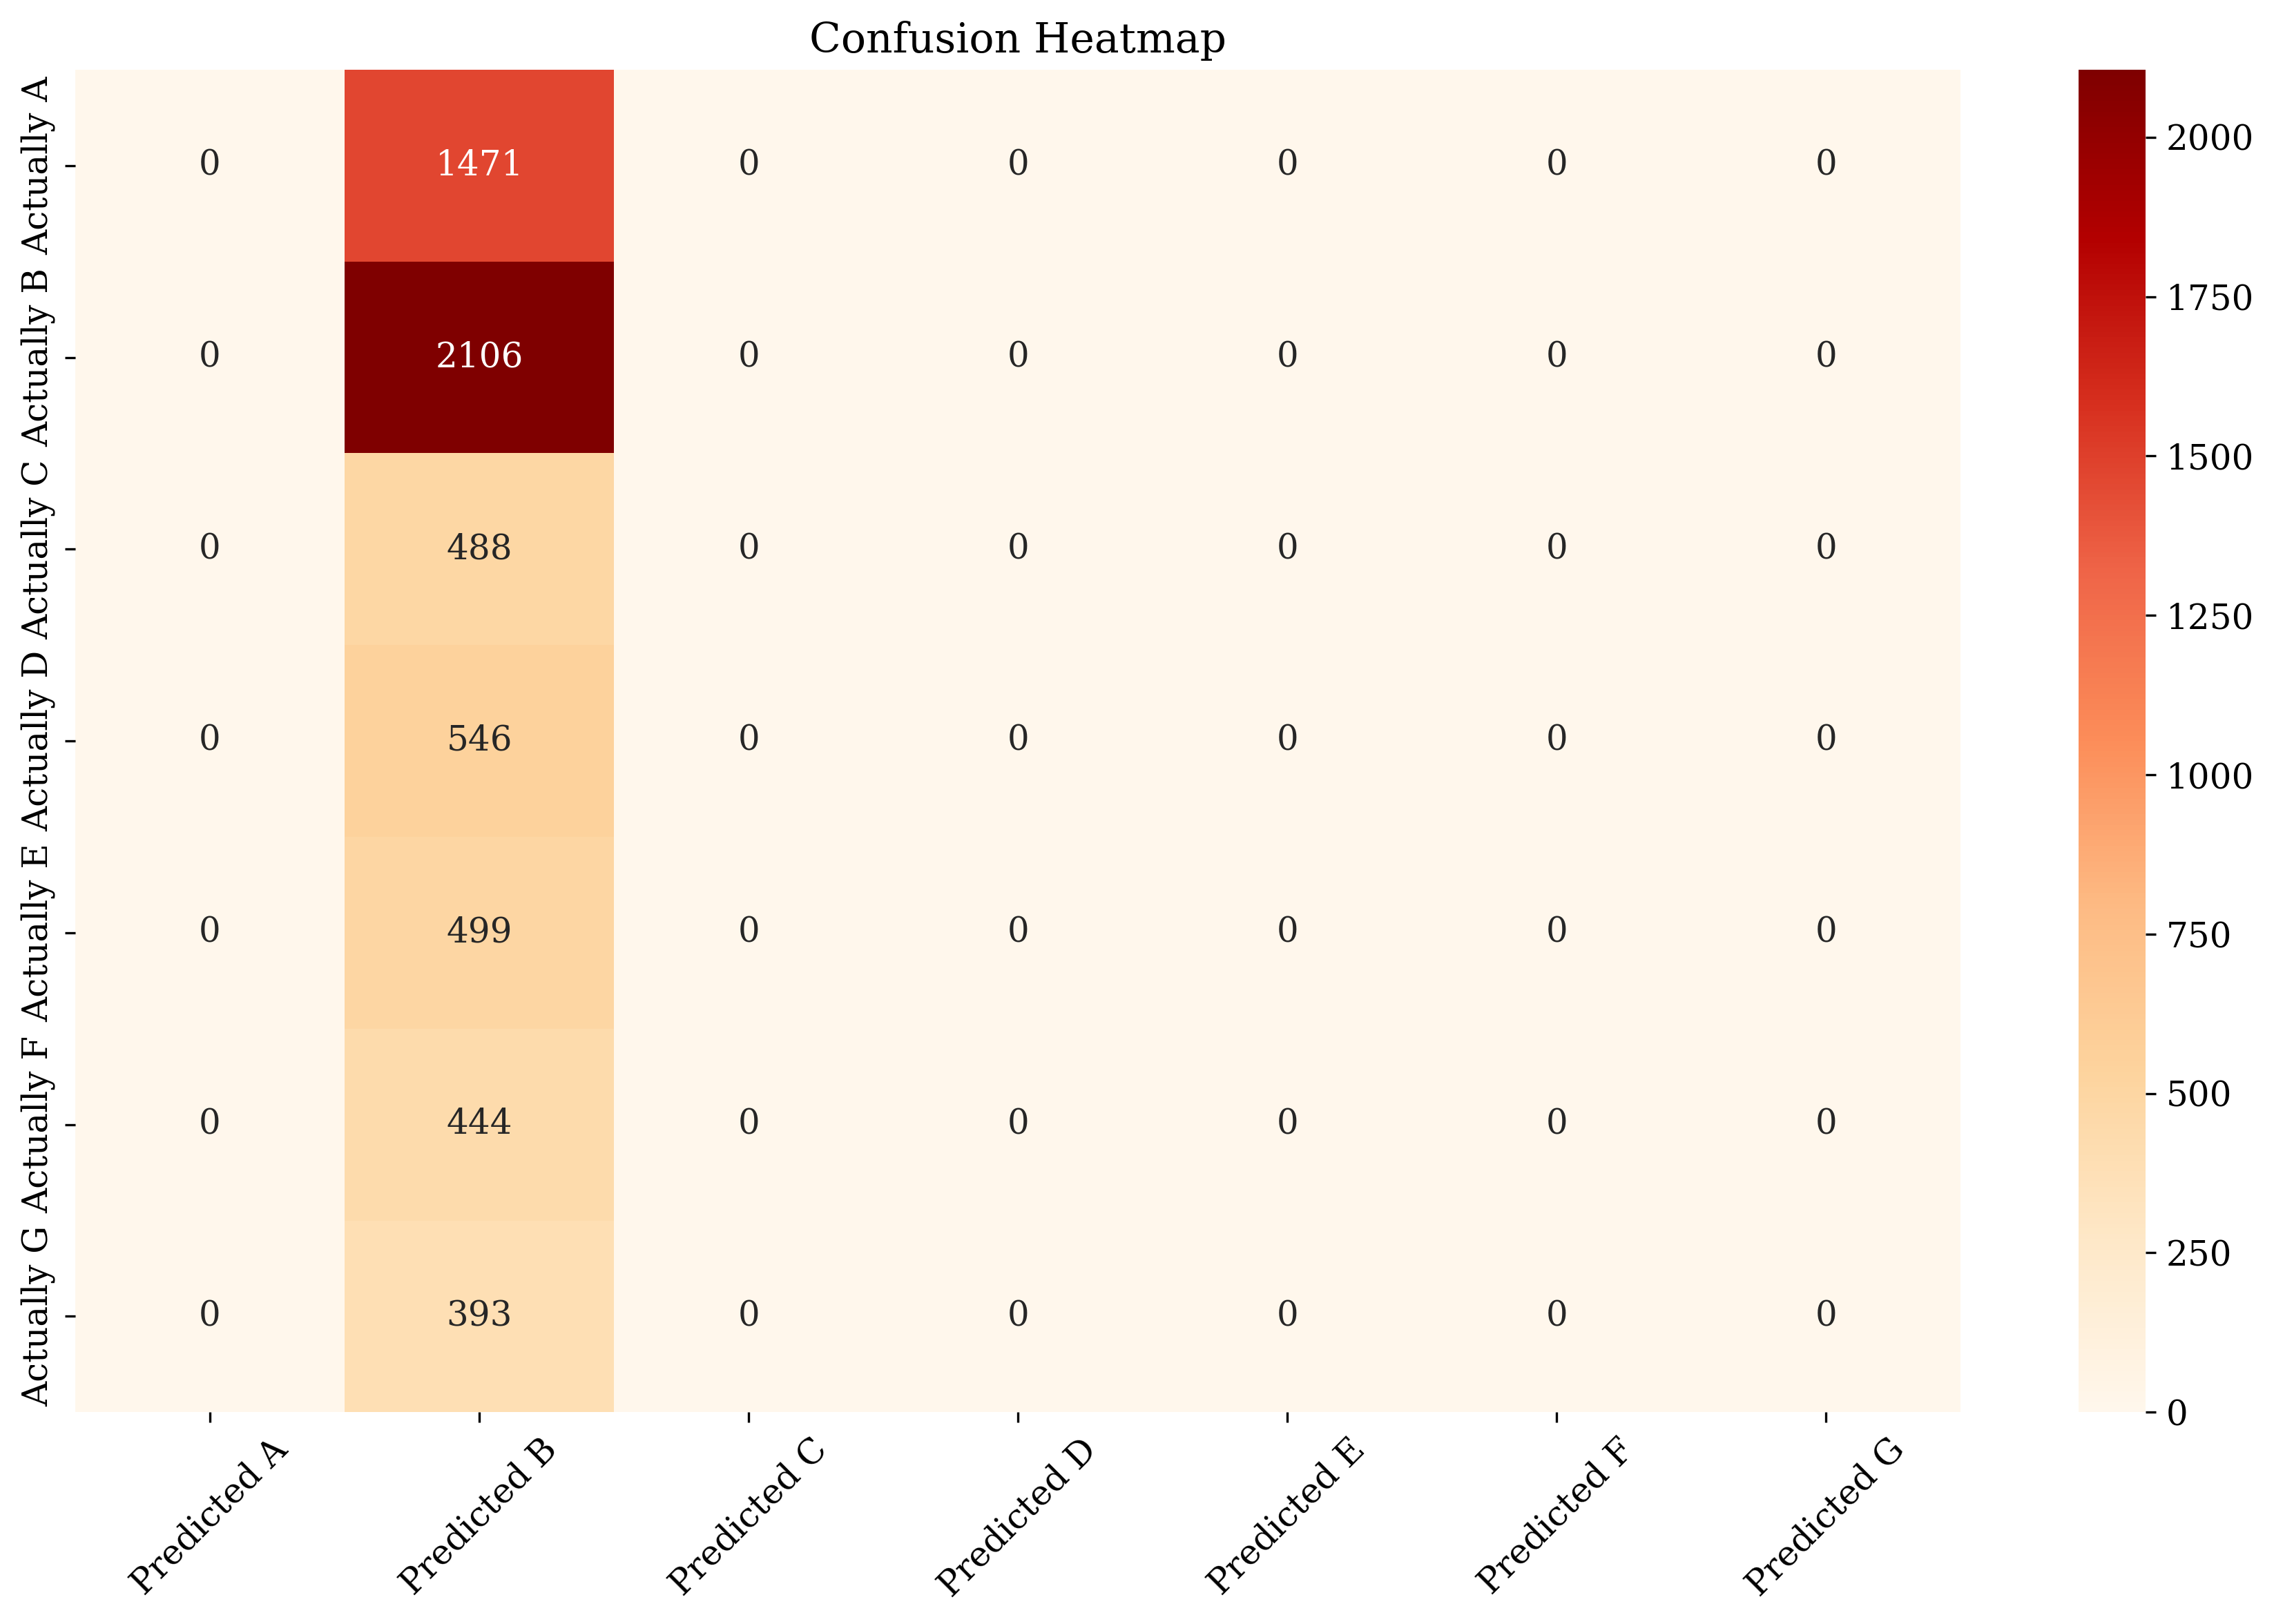

              precision    recall  f1-score   support

           A       0.00      0.00      0.00      1471
           B       0.35      1.00      0.52      2106
           C       0.00      0.00      0.00       488
           D       0.00      0.00      0.00       546
           E       0.00      0.00      0.00       499
           F       0.00      0.00      0.00       444
           G       0.00      0.00      0.00       393

    accuracy                           0.35      5947
   macro avg       0.05      0.14      0.07      5947
weighted avg       0.13      0.35      0.19      5947



In [53]:
model_utils.PlotConfusionMatrix(logreg_reduced, X_test_transformed, y_test)

---
<a id='dim_reduc'></a>
## Reducing Dimensionality with PCA

In [62]:
import logreg_utils
reload(logreg_utils)
from sklearn.decomposition import PCA

X_train_sm, X_test, y_train_sm, y_test = logreg_utils.GenerateSMOTE(df)

X_train_sm_transformed = col_transformer.fit_transform(X_train_sm)
X_test_transformed = col_transformer.transform(X_test)

# Instantiate PCA
my_pca = PCA()

# Fit to scaled data
X_train_pca = my_pca.fit_transform(X_train_sm_transformed)
X_test_pca = my_pca.transform(X_test_transformed)

In [63]:
X_train_pca.shape

(58961, 83)

In [64]:
logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_pca, y_train_sm)
logreg.score(X_test_pca, y_test)

0.41029090297629056

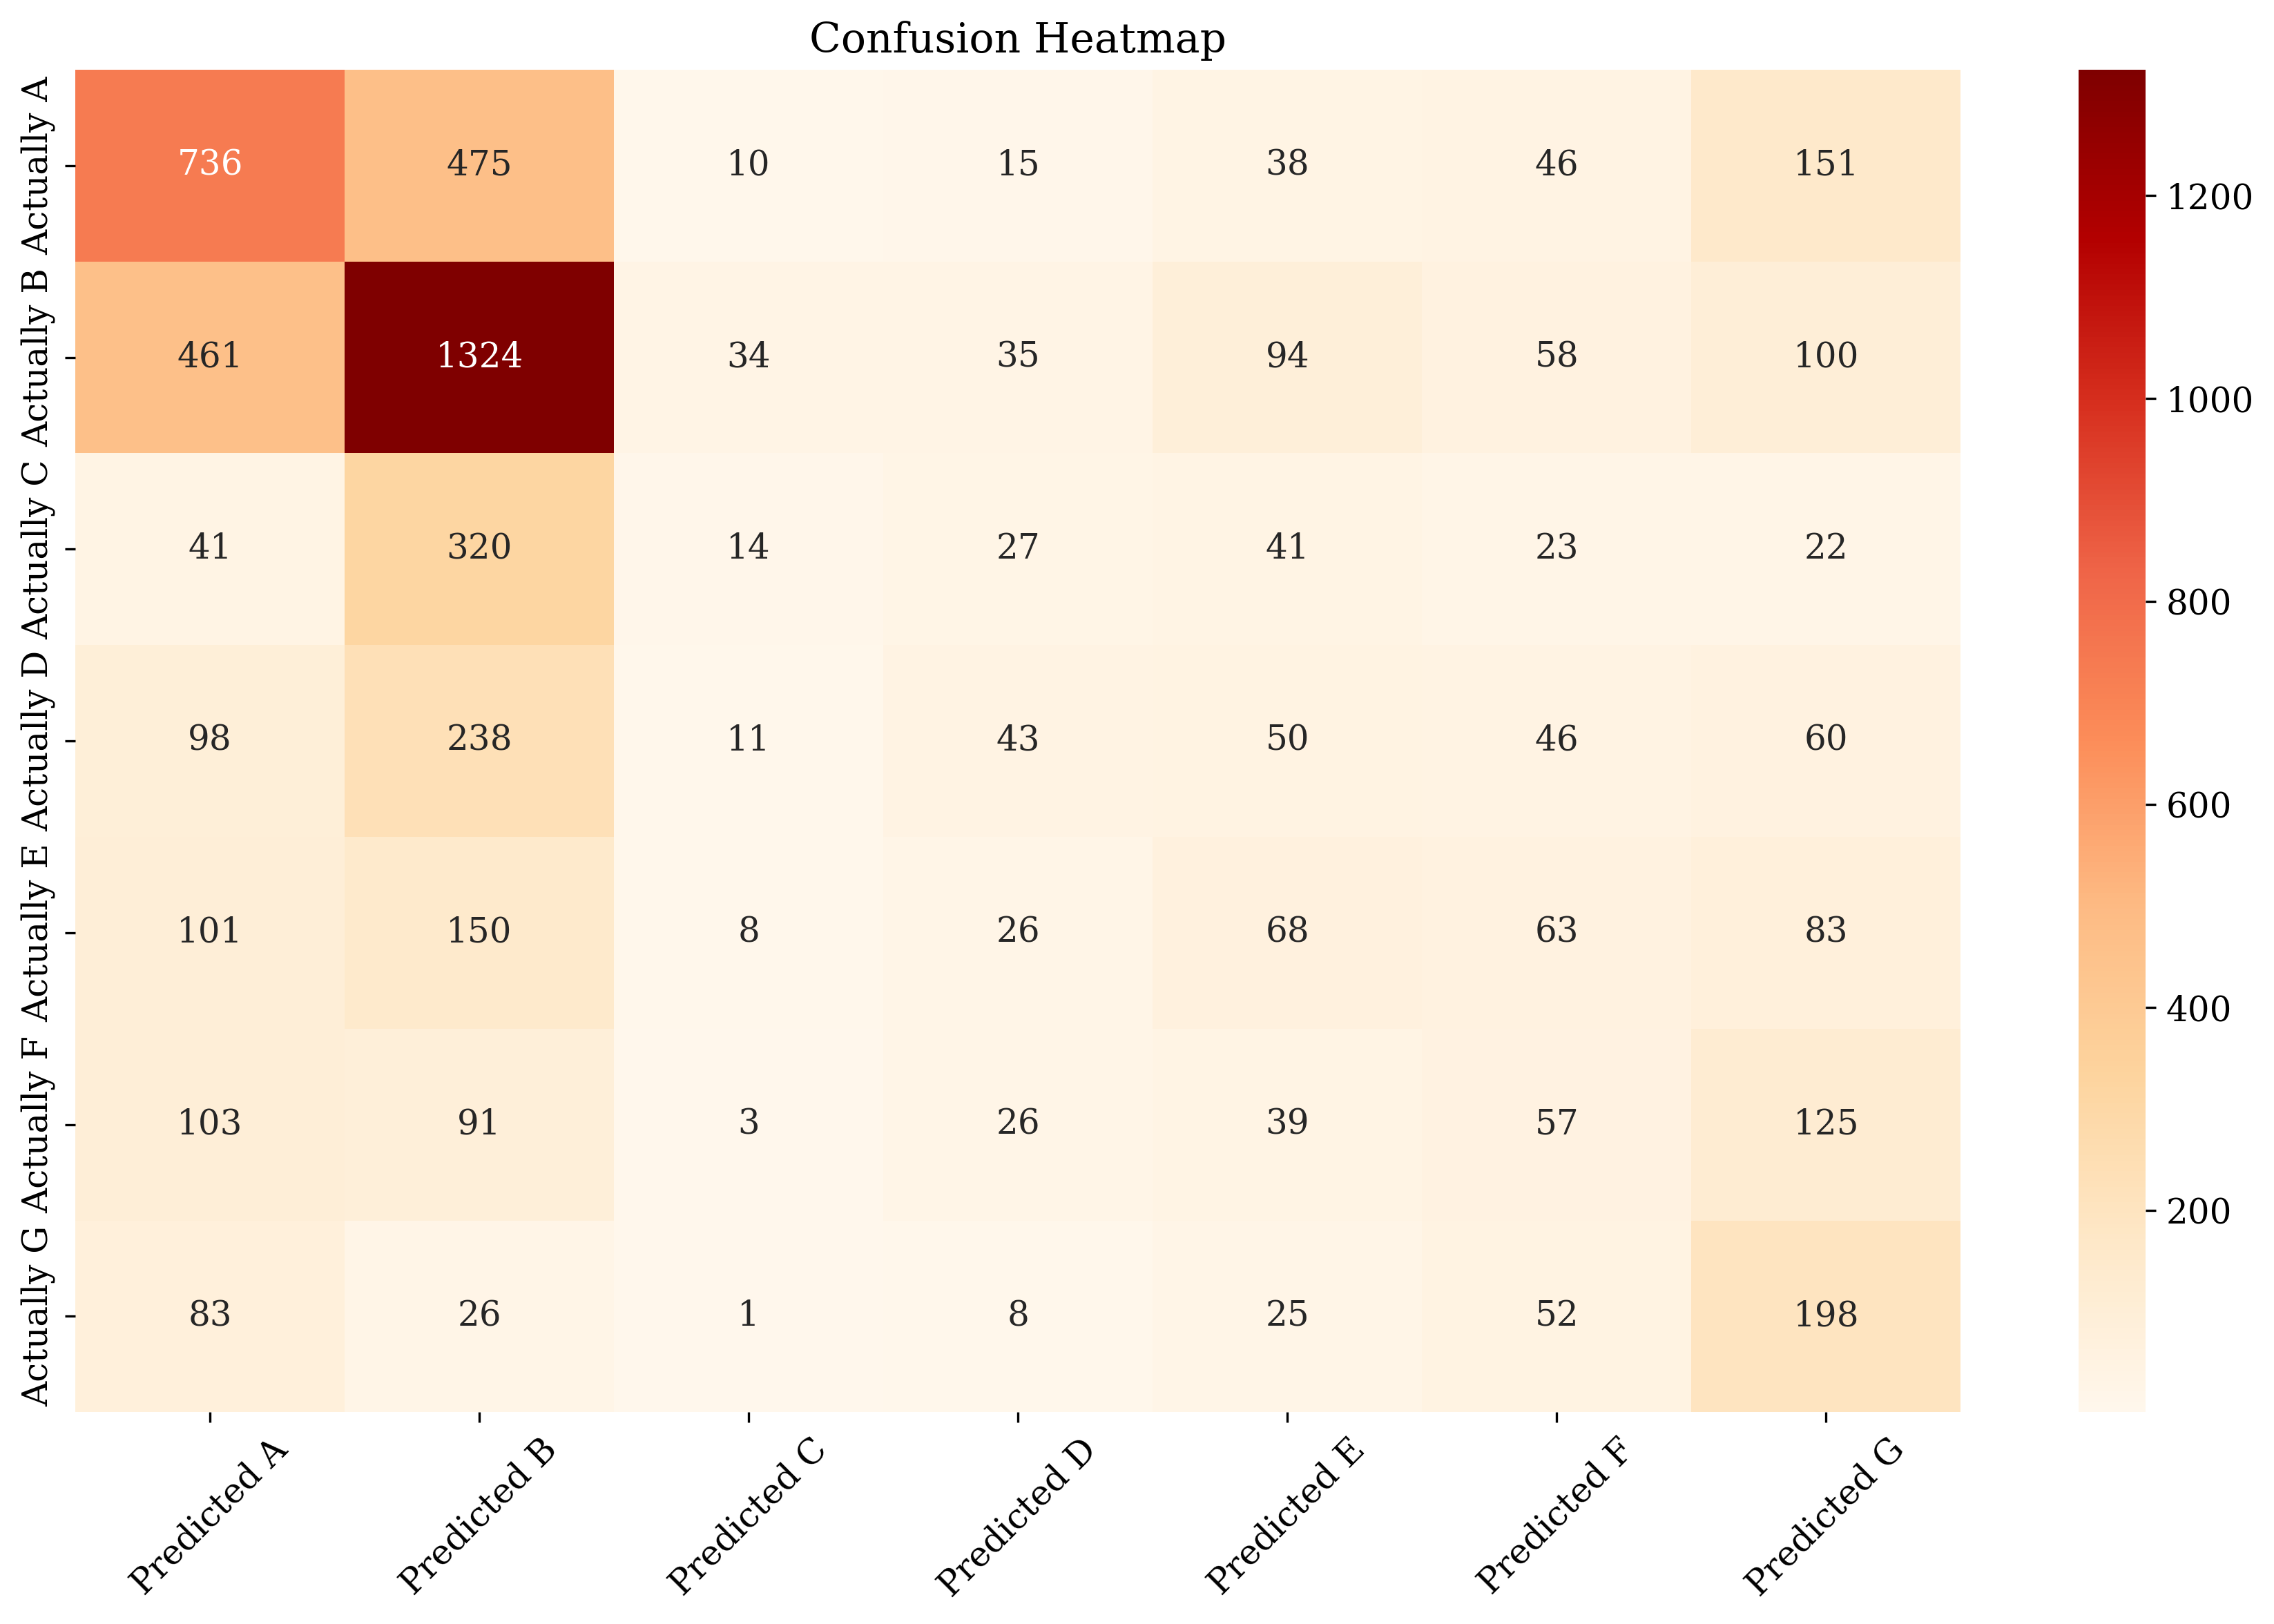

              precision    recall  f1-score   support

           A       0.45      0.50      0.48      1471
           B       0.50      0.63      0.56      2106
           C       0.17      0.03      0.05       488
           D       0.24      0.08      0.12       546
           E       0.19      0.14      0.16       499
           F       0.17      0.13      0.14       444
           G       0.27      0.50      0.35       393

    accuracy                           0.41      5947
   macro avg       0.28      0.29      0.27      5947
weighted avg       0.37      0.41      0.38      5947



In [65]:
model_utils.PlotConfusionMatrix(logreg, X_test_pca, y_test)

In [66]:
my_pca.explained_variance_ratio_

array([6.41023647e-01, 2.34376374e-01, 1.00346509e-01, 1.46402842e-02,
       2.54541080e-03, 1.16827592e-03, 9.82869957e-04, 6.52766446e-04,
       5.81943651e-04, 4.75046913e-04, 3.91614431e-04, 3.72611302e-04,
       3.52359995e-04, 2.90067174e-04, 2.48210200e-04, 2.24294009e-04,
       2.09834423e-04, 1.98557026e-04, 1.58862370e-04, 1.53923321e-04,
       1.36485813e-04, 1.04744521e-04, 4.42835228e-05, 3.37868439e-05,
       3.22884612e-05, 2.46009532e-05, 1.99474964e-05, 1.85104666e-05,
       1.42684755e-05, 1.33885059e-05, 1.11346244e-05, 1.00945620e-05,
       9.51033747e-06, 9.13512866e-06, 7.95100306e-06, 7.63656594e-06,
       6.98355879e-06, 6.81909247e-06, 6.48713586e-06, 6.27943361e-06,
       5.71088244e-06, 5.60591061e-06, 5.15547575e-06, 4.85425581e-06,
       3.92409402e-06, 3.85272594e-06, 3.59402033e-06, 3.54425720e-06,
       3.41055349e-06, 3.32099722e-06, 3.26163244e-06, 3.14343705e-06,
       2.78347511e-06, 2.67657333e-06, 2.62469761e-06, 2.50224545e-06,
      

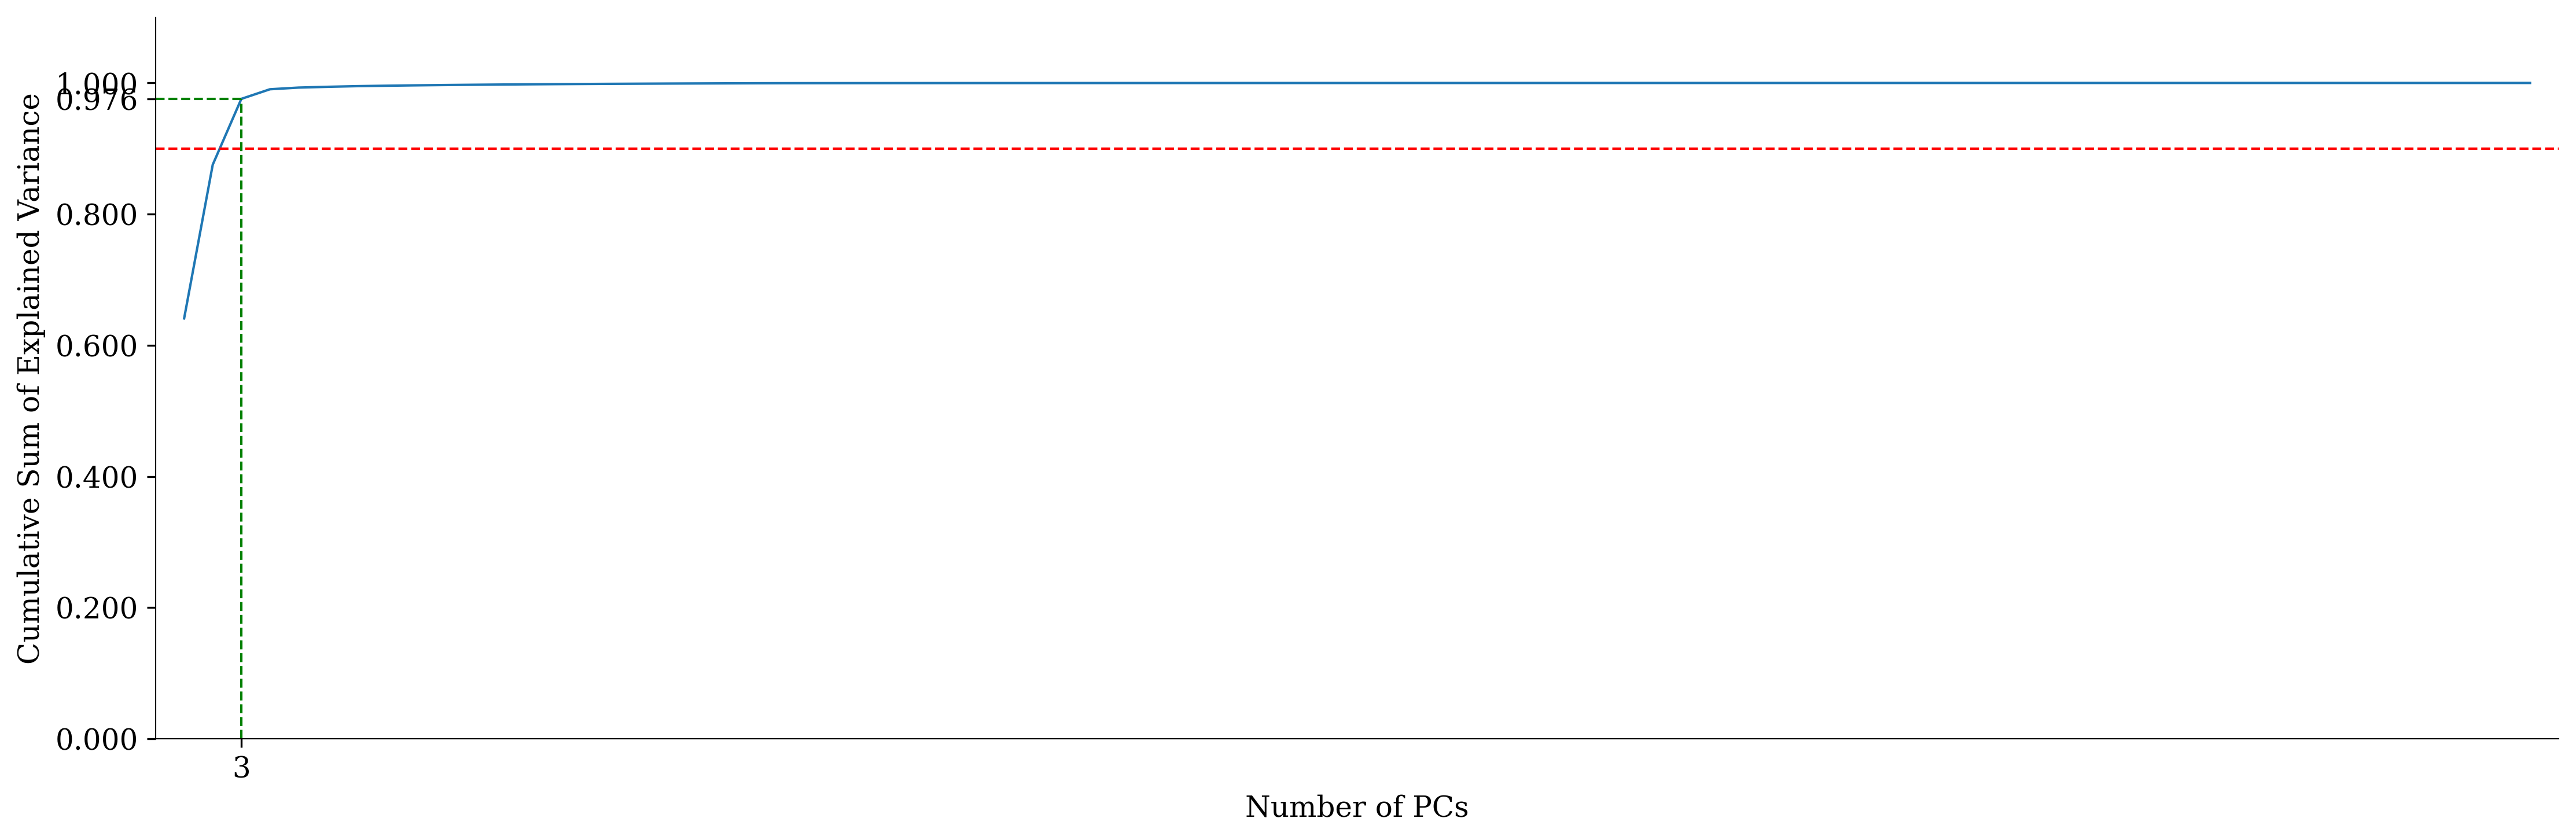

In [67]:
utils.PlotVarianceRatio(my_pca)

In [68]:
# Instantiate PCA
my_pca = PCA(n_components=0.9)

# Fit to scaled data
X_train_pca = my_pca.fit_transform(X_train_sm_transformed)
X_test_pca = my_pca.transform(X_test_transformed)

In [69]:
logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_pca, y_train_sm)
logreg.score(X_test_pca, y_test)

0.13502606356145955

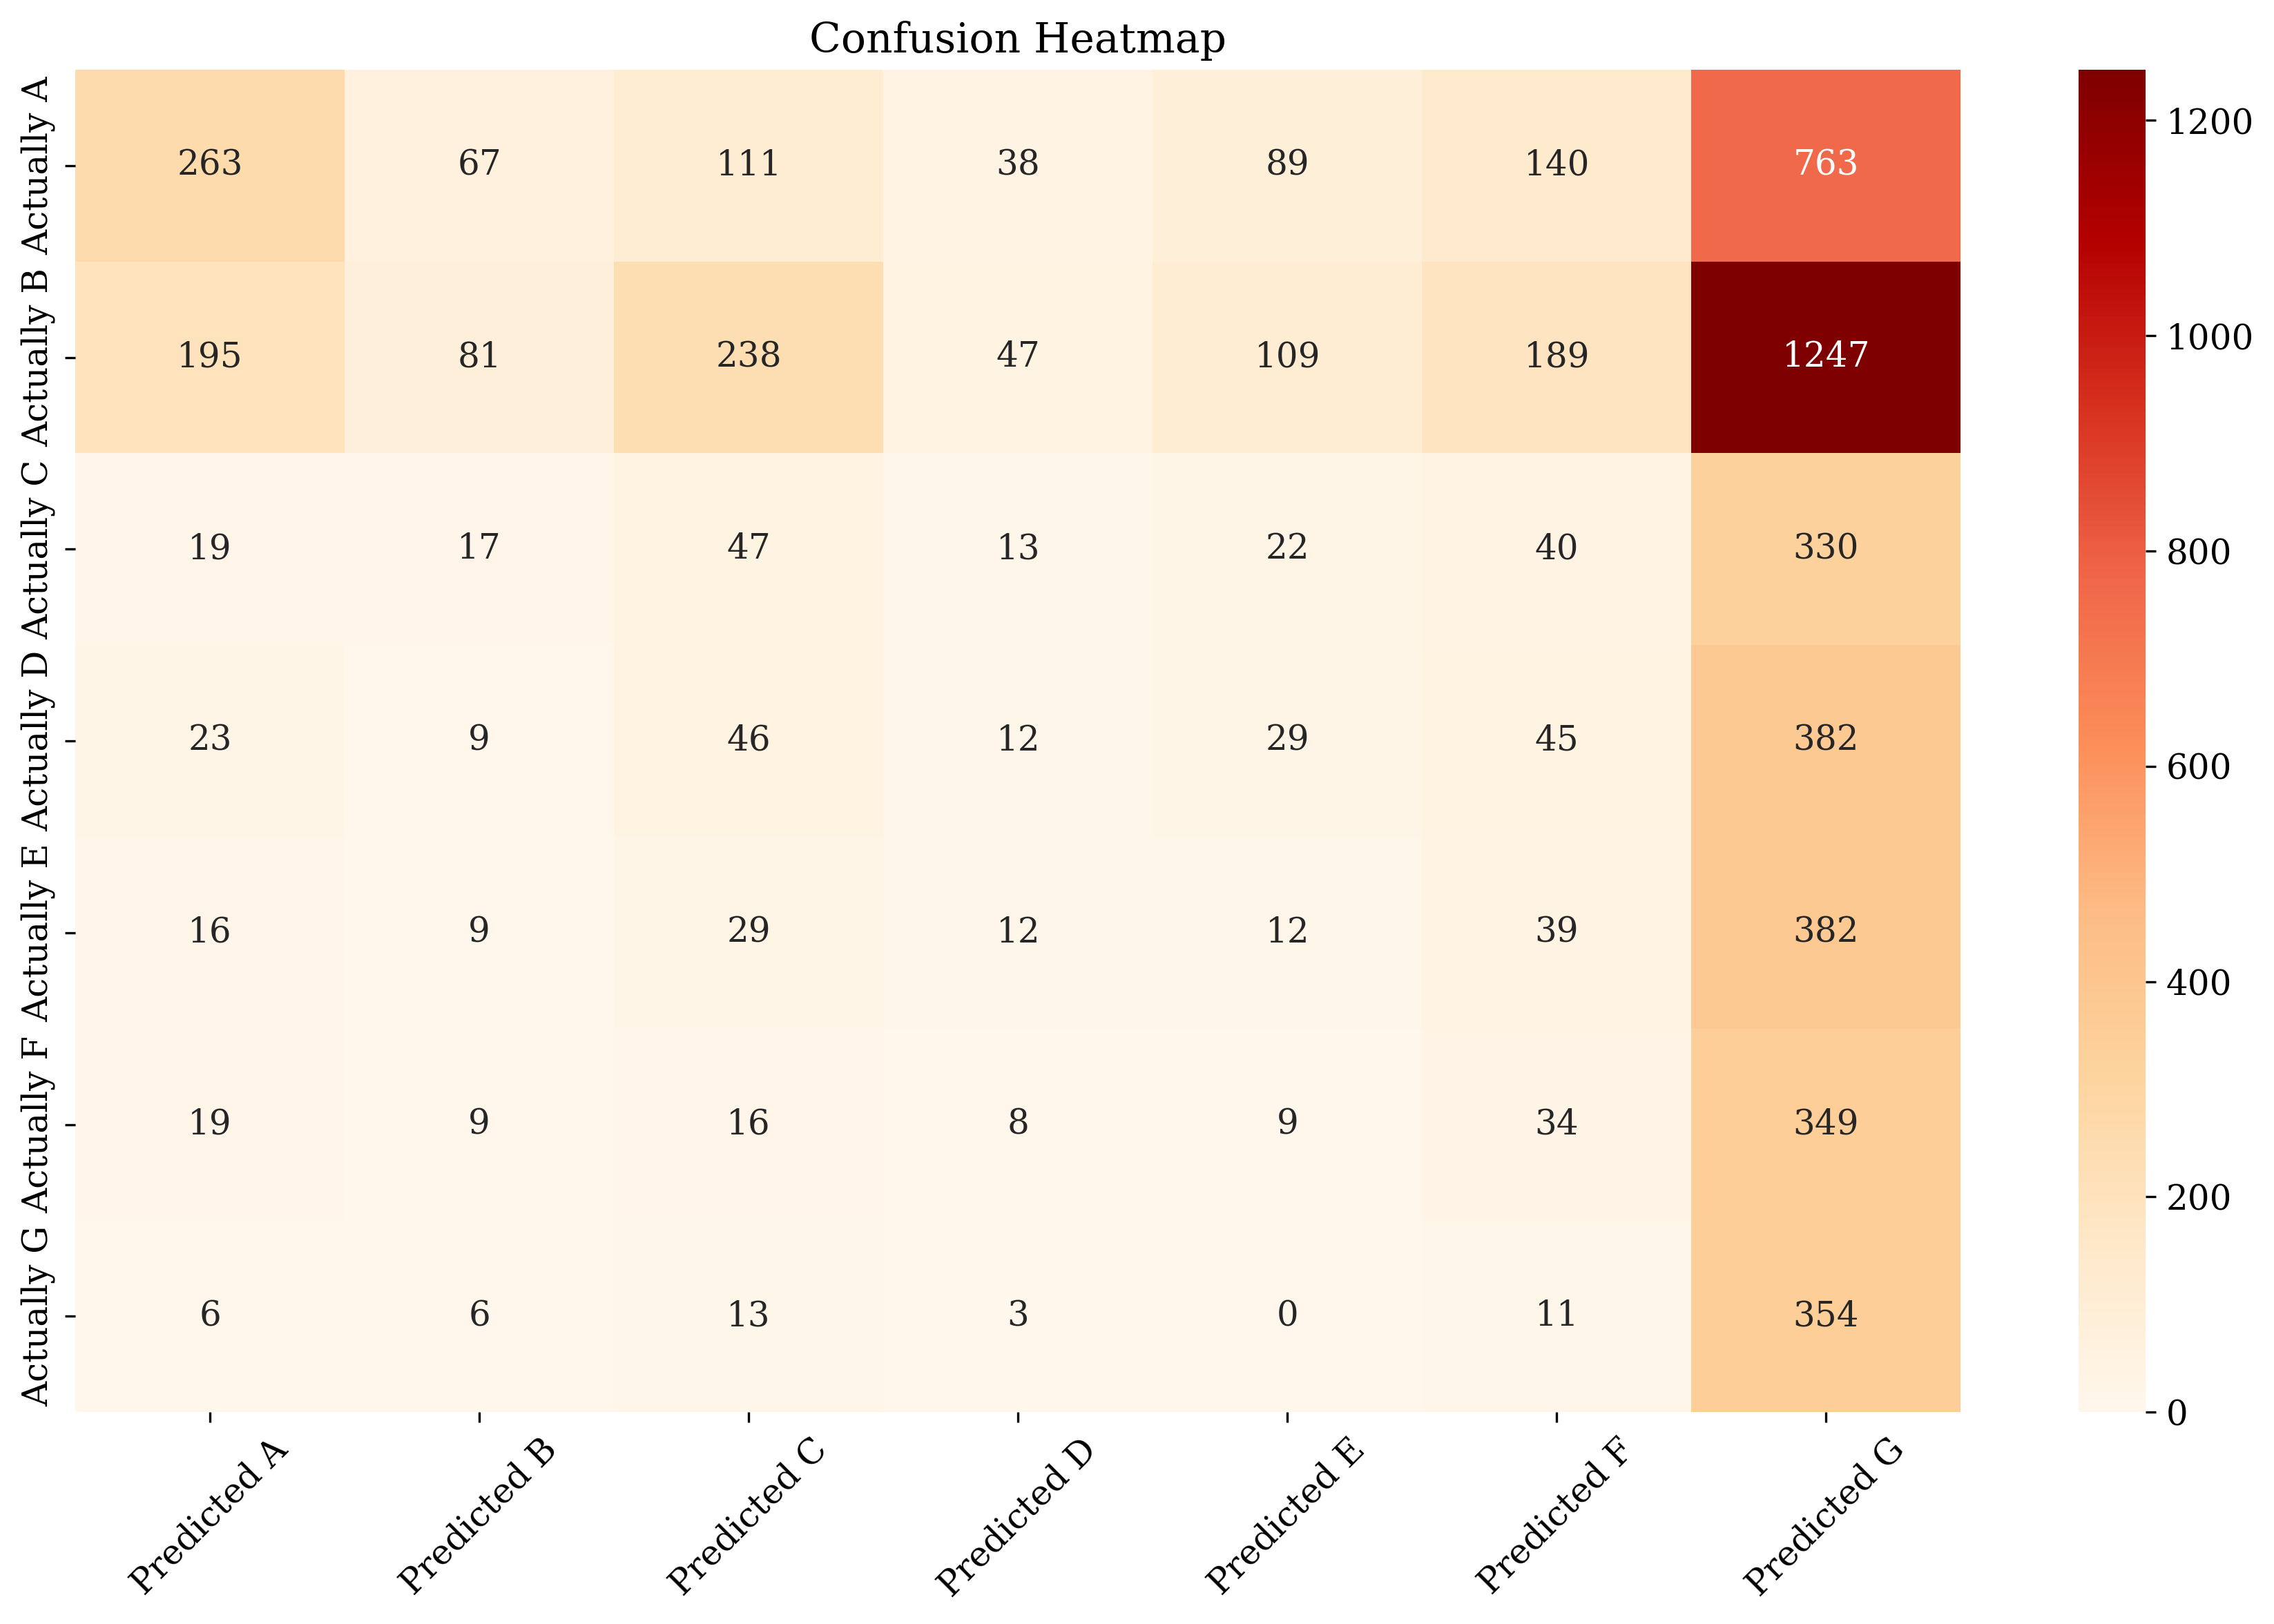

              precision    recall  f1-score   support

           A       0.49      0.18      0.26      1471
           B       0.41      0.04      0.07      2106
           C       0.09      0.10      0.10       488
           D       0.09      0.02      0.04       546
           E       0.04      0.02      0.03       499
           F       0.07      0.08      0.07       444
           G       0.09      0.90      0.17       393

    accuracy                           0.14      5947
   macro avg       0.18      0.19      0.10      5947
weighted avg       0.30      0.14      0.12      5947



In [70]:
model_utils.PlotConfusionMatrix(logreg, X_test_pca, y_test)

It seems that by reducing the dimensionality we incur a big loss in accuracy.

---
<a id='optimisation'></a>
## Model Optimisation

In [77]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

# Create cache
cachedir = mkdtemp()

estimators = [('normalise', col_transformer),
              ('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [
    {
        'normalise': [col_transformer, RobustScaler()],
        'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
        'logreg__penalty': ['l1', 'l2'], 
        'logreg__C': [10**x for x in range(-5, 2)],
        'logreg__solver': ['lbfgs', 'liblinear']
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
fittedgrid = grid.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


In [78]:
fittedgrid.best_params_

{'logreg__C': 0.1,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear',
 'normalise': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard scale', StandardScaler(),
                                  ['avg_tempmax', 'avg_temp', 'avg_humidity',
                                   'avg_precip', 'avg_dew', 'avg_windspeed',
                                   'avg_winddir', 'avg_pressure',
                                   'tempmax_variance', 'tempmax_delta',
                                   'temp_variance', 'temp_delta',
                                   'humidity_variance', 'humidity_delta',
                                   'precip_delta', 'dew_variance', 'dew_delta',
                                   'windspeed_variance', 'windspeed_delta',
                                   'winddir_variance', 'winddir_delta',
                                   'pressure_variance', 'pressure_delta']),
                                 ('minmax scale', MinMaxSca

In [79]:
# Mean test score for each CV fold
fittedgrid.cv_results_['mean_test_score']

array([       nan,        nan,        nan,        nan,        nan,
              nan, 0.14285714, 0.14285714, 0.17462388, 0.15589988,
       0.15589988, 0.15927504, 0.25313357, 0.19243234, 0.25335405,
       0.22652242, 0.16819582, 0.26951764, 0.26174944, 0.1885145 ,
       0.27139993, 0.26907636, 0.16767009, 0.274351  ,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.18686934, 0.18686934, 0.19718126, 0.18790392, 0.1675175 ,
       0.19962354, 0.2828143 , 0.19244929, 0.2815762 , 0.27872657,
       0.16821278, 0.28449316, 0.28378104, 0.18742903, 0.28574838,
       0.2955515 , 0.1681789 , 0.29789205,        nan,        nan,
              nan,        nan,        nan,        nan, 0.25111529,
       0.19007481, 0.25762799, 0.27263797, 0.16848417, 0.270467  ,
       0.29417775, 0.19283937, 0.29063308, 0.28600247, 0.16814495,
       0.28605346, 0.31766813, 0.18910807, 0.31687097, 0.32842088,
       0.16851811, 0.32760682,        nan,        nan,        

In [80]:
fittedgrid.score(X_test, y_test)

0.41012275096687406

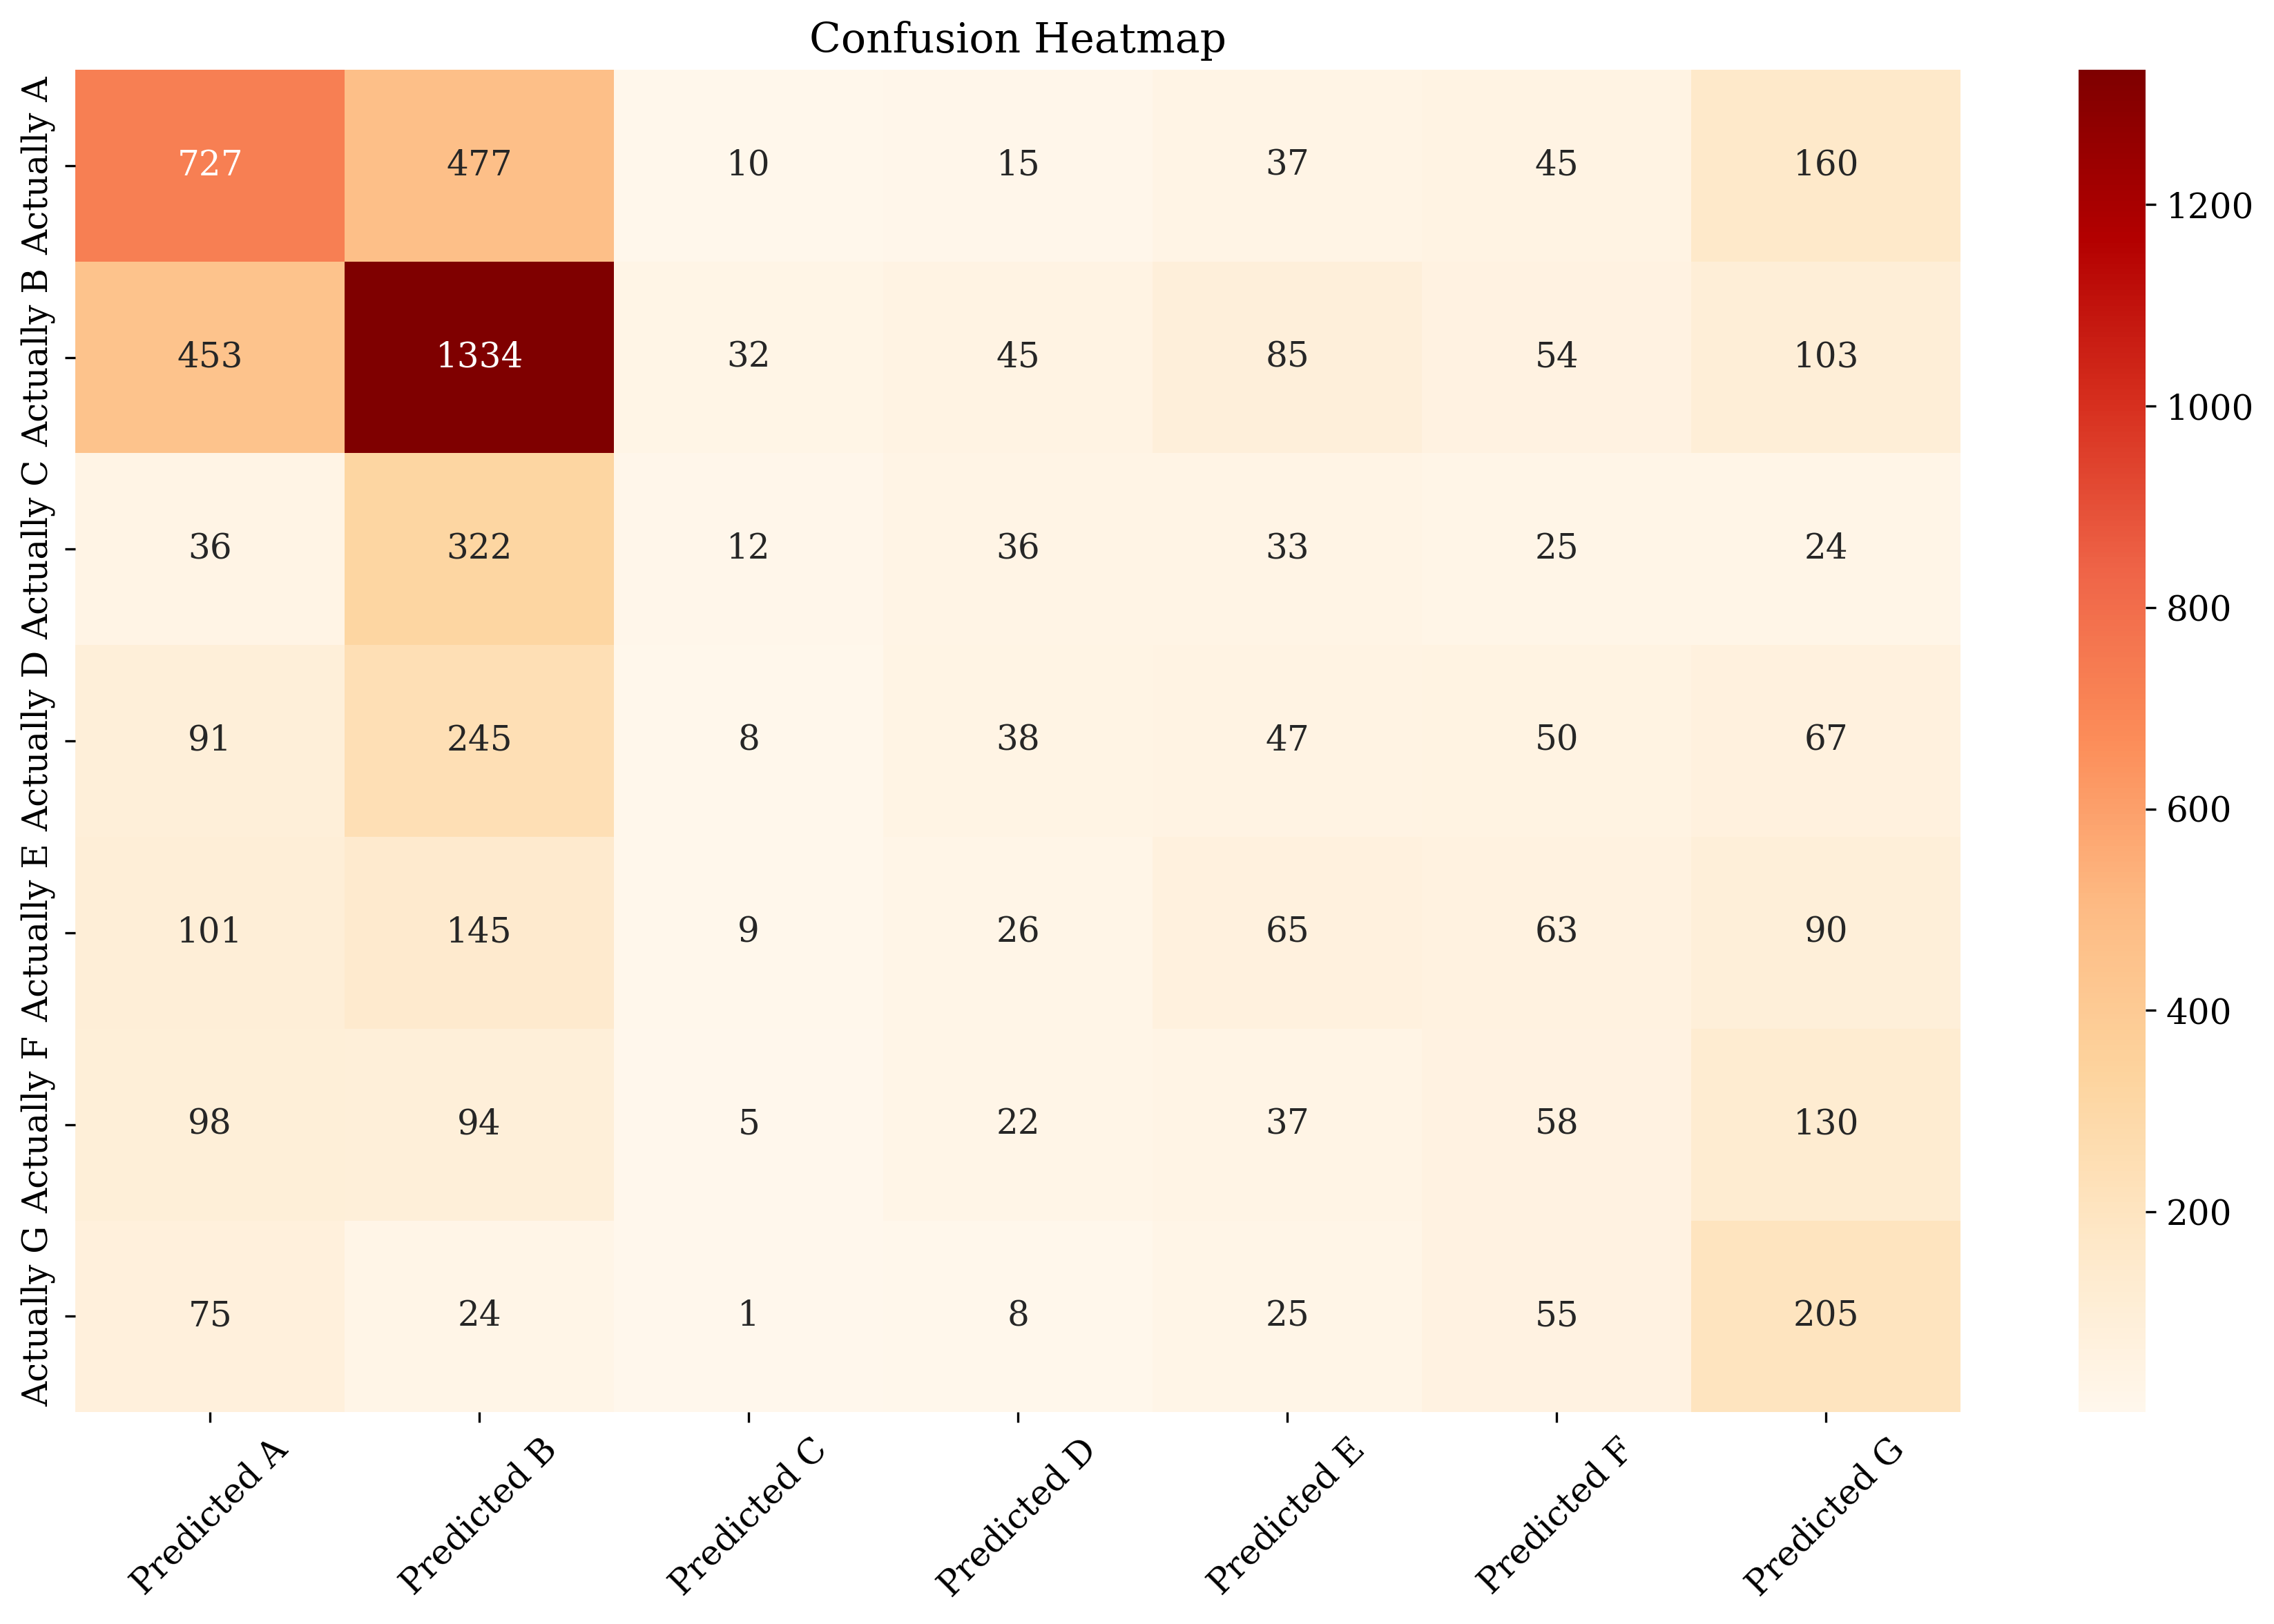

              precision    recall  f1-score   support

           A       0.46      0.49      0.48      1471
           B       0.51      0.63      0.56      2106
           C       0.16      0.02      0.04       488
           D       0.20      0.07      0.10       546
           E       0.20      0.13      0.16       499
           F       0.17      0.13      0.15       444
           G       0.26      0.52      0.35       393

    accuracy                           0.41      5947
   macro avg       0.28      0.29      0.26      5947
weighted avg       0.37      0.41      0.38      5947



In [81]:
model_utils.PlotConfusionMatrix(fittedgrid, X_test, y_test)

---
<a id='save'></a>
#### Saving the model

In [87]:
# import pickle

# pickle.dump(fittedgrid, open('models/logreg_model.sav', 'wb'))

<a id='load'></a>
#### Loading the model

In [ ]:
# fittedgrid = pickle.load(open('models/logreg_model.sav', 'rb'))

---
<a id='conc'></a>
## Remarks on Logistic Regression